# **1. Data Import and Preparation**

This section loads IGO.AX price and volume, ASX200 benchmark returns, and news data.  
It filters all datasets to the analysis window (from 10 days before to 60 days after the March 2019 earnings event).

In [ ]:
import pandas as pd
import numpy as np

# Load IGO and ASX200 data
igo = pd.read_csv('STOCK_AU_XASX_IGO.csv')
asx = pd.read_excel('ASX_DailyReturns.xlsx')

# Parse date columns (dayfirst for Australian formats)
igo['Date'] = pd.to_datetime(igo['Date'], dayfirst=True)
asx['Date'] = pd.to_datetime(asx['Date'], dayfirst=True)

# Filter for analysis window (event window)
start = pd.to_datetime('2019-04-29')
end = pd.to_datetime('2019-07-24')
igo = igo[(igo['Date'] >= start) & (igo['Date'] <= end)].copy()
asx = asx[(asx['Date'] >= start) & (asx['Date'] <= end)].copy()

# Sort both dataframes by date (ascending)
igo = igo.sort_values('Date').reset_index(drop=True)
asx = asx.sort_values('Date').reset_index(drop=True)

# Fix volume formatting if needed
igo['Volume'] = igo['Volume'].astype(str).str.replace(',', '').astype(float)

# Rename ASX200 return column if needed
if 'ASX Daily Returns (%)' in asx.columns:
    asx = asx.rename(columns={'ASX Daily Returns (%)': 'ASX200_Return'})



<ipython-input-2-2f542855fb54>:9: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  igo['Date'] = pd.to_datetime(igo['Date'], dayfirst=True)


# **2. Daily Returns and Abnormal Returns (AR)**

- Calculates IGO's daily returns (%)
- Merges with ASX200 daily returns
- Computes abnormal returns (AR) for the event window


In [ ]:
# Calculate daily returns for IGO (in percent)
igo['IGO_Return'] = igo['Close'].pct_change() * 100

# Merge IGO returns with ASX200 benchmark on Date
df = pd.merge(
    igo[['Date', 'Close', 'Volume', 'IGO_Return']],
    asx[['Date', 'ASX200_Return']],
    on='Date',
    how='inner'
)

# Calculate abnormal returns (AR)
df['AR'] = df['IGO_Return'] - df['ASX200_Return']
df = df.dropna(subset=['IGO_Return', 'ASX200_Return', 'AR'])
df.head()



,Date,Close,Volume,IGO_Return,ASX200_Return,AR
1,2019-04-30,4.414,2469731.0,-1.780151,-0.534633,-1.245518
2,2019-05-01,4.533,13327093.0,2.695967,0.796775,1.899192
3,2019-05-02,4.583,2558671.0,1.103022,-0.588152,1.691175
4,2019-05-03,4.573,1117580.0,-0.218198,-0.041020,-0.177178
5,2019-05-06,4.345,2627854.0,-4.985786,-0.822311,-4.163475


# **3. Cumulative Abnormal Returns (CAR) for Key Windows**

This cell computes CAR for rolling windows:  
5, 10, 15, ..., 60 trading days after the event.


In [ ]:
CAR_windows = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
CAR_results = []
ar_values = df['AR'].reset_index(drop=True)
for k in CAR_windows:
    car = ar_values[1:k+1].sum()
    CAR_results.append({'Start': 1, 'End': k, 'CAR': f'CAR(t+1,t+{k})', 'Value (%)': round(car, 4)})
df_car = pd.DataFrame(CAR_results)
df_car


,Start,End,CAR,Value (%)
0,1,5,"CAR(t+1,t+5)",3.3856
1,1,10,"CAR(t+1,t+10)",3.8306
2,1,15,"CAR(t+1,t+15)",5.9549
3,1,20,"CAR(t+1,t+20)",3.5958
4,1,25,"CAR(t+1,t+25)",-0.9593
5,1,30,"CAR(t+1,t+30)",-1.2518
6,1,35,"CAR(t+1,t+35)",0.5128
7,1,40,"CAR(t+1,t+40)",2.3535
8,1,45,"CAR(t+1,t+45)",2.3489
9,1,50,"CAR(t+1,t+50)",3.5549


# **4. Analysis**

## **4.1 Cumulative Return Over/Underperformance (IGO vs ASX200) – NO News Overlay**

This plot compares the cumulative return of IGO and the ASX200 from the day before the announcement to 60 trading days after, shading periods of over- and underperformance.


<ipython-input-5-3905639a6961>:9: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  igo['Date'] = pd.to_datetime(igo['Date'], dayfirst=True)


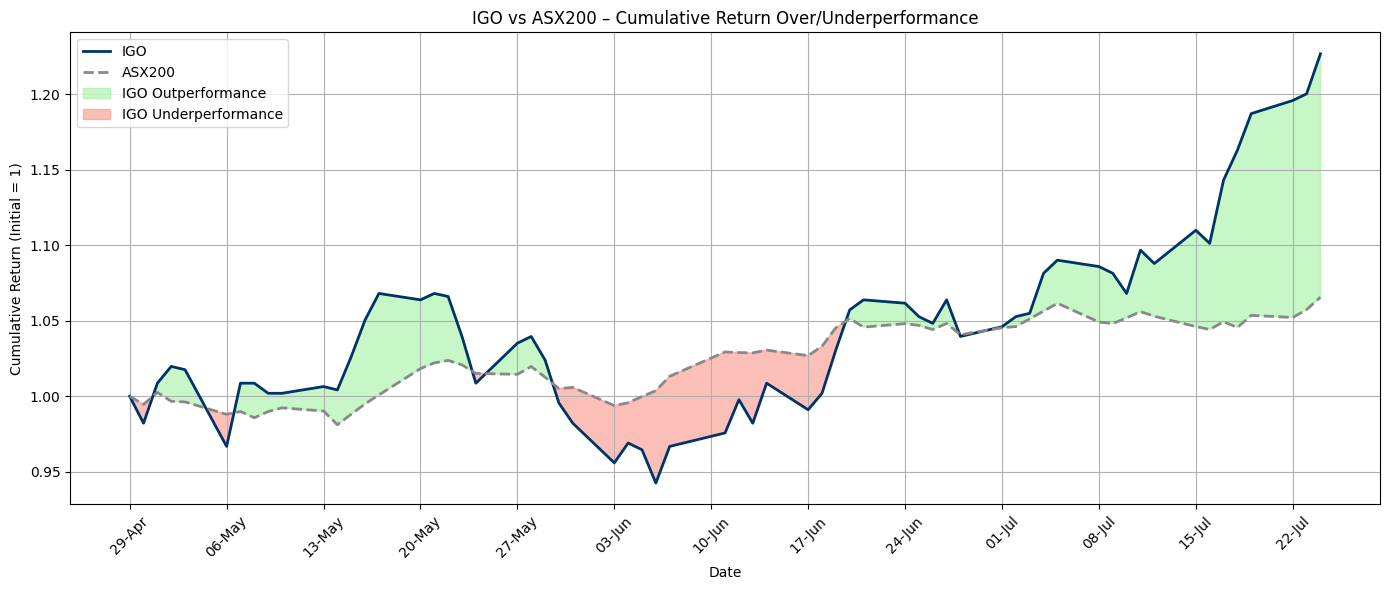

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load and prepare data
igo = pd.read_csv('STOCK_AU_XASX_IGO.csv')
asx = pd.read_excel('ASX_DailyReturns.xlsx')
igo['Date'] = pd.to_datetime(igo['Date'], dayfirst=True)
asx['Date'] = pd.to_datetime(asx['Date'], dayfirst=True)
start = pd.to_datetime('2019-04-29')
end = pd.to_datetime('2019-07-24')
igo = igo[(igo['Date'] >= start) & (igo['Date'] <= end)].sort_values('Date').reset_index(drop=True)
asx = asx[(asx['Date'] >= start) & (asx['Date'] <= end)].sort_values('Date').reset_index(drop=True)
asx = asx.rename(columns={'ASX Daily Returns (%)': 'ASX200_Return'}) if 'ASX Daily Returns (%)' in asx.columns else asx

# Calculate cumulative returns (normalized)
igo['IGO_Return'] = igo['Close'].pct_change() * 100
igo_cumret = (1 + igo['IGO_Return'].fillna(0) / 100).cumprod()
asx_cumret = (1 + asx['ASX200_Return'].fillna(0) / 100).cumprod()
igo_cumret = igo_cumret / igo_cumret.iloc[0]
asx_cumret = asx_cumret / asx_cumret.iloc[0]

# Build aligned dataframe
df_cmp = pd.DataFrame({
    "Date": igo['Date'].values,
    "IGO (Cumulative Return)": igo_cumret.values,
    "ASX200 (Cumulative Return)": asx_cumret.values
}).set_index("Date")

# Plot
igo_cr = df_cmp["IGO (Cumulative Return)"]
asx_cr = df_cmp["ASX200 (Cumulative Return)"]
dates = df_cmp.index

plt.figure(figsize=(14, 6))
plt.plot(dates, igo_cr, label="IGO", color="#003366", linewidth=2)
plt.plot(dates, asx_cr, label="ASX200", color="#888888", linestyle="--", linewidth=2)
plt.fill_between(dates, igo_cr, asx_cr, where=(igo_cr > asx_cr), interpolate=True, color="lightgreen", alpha=0.5, label="IGO Outperformance")
plt.fill_between(dates, igo_cr, asx_cr, where=(igo_cr < asx_cr), interpolate=True, color="salmon", alpha=0.5, label="IGO Underperformance")
plt.title("IGO vs ASX200 – Cumulative Return Over/Underperformance")
plt.ylabel("Cumulative Return (Initial = 1)")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.grid(True)

# Cambia qui:
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## **4.2 Daily Abnormal Returns (AR) Barplot – NO News Overlay**

This plot shows IGO's daily abnormal returns (AR) versus ASX200, highlighting positive and negative days, for the event window.


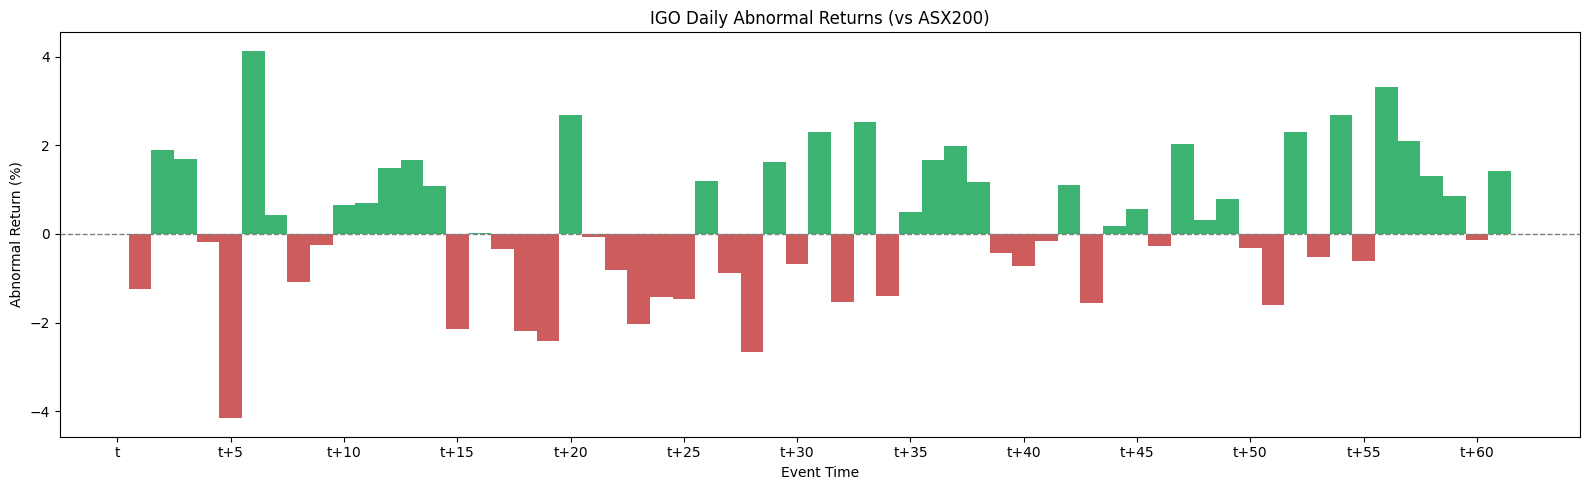

In [ ]:
# Prepare AR dataframe
df_daily = pd.DataFrame({
    "Date": igo['Date'],
    "IGO_Return": igo['IGO_Return'].values,
    "ASX200_Return": asx['ASX200_Return'].values
})
df_daily['AR'] = df_daily['IGO_Return'] - df_daily['ASX200_Return']

# Custom x-axis labels for event time: t, t+1, ..., t+N
labels = ['t'] + [f't+{i}' for i in range(1, len(df_daily))]

plt.figure(figsize=(16, 5))
plt.bar(np.arange(len(df_daily)), df_daily['AR'], color=np.where(df_daily['AR'] >= 0, "mediumseagreen", "indianred"), width=1.0, edgecolor="none")
plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.title("IGO Daily Abnormal Returns (vs ASX200)")
plt.ylabel("Abnormal Return (%)")
plt.xlabel("Event Time")
# Show every 5th label
step = 5
plt.xticks(ticks=np.arange(0, len(df_daily), step), labels=[labels[i] for i in range(0, len(labels), step)], rotation=0)
plt.tight_layout()
plt.show()


## **4.3 Cumulative Abnormal Return (CAR) by Window – NO News Overlay**

This plot shows cumulative abnormal return (CAR) for selected windows (5, 10, ..., 60 days after event).


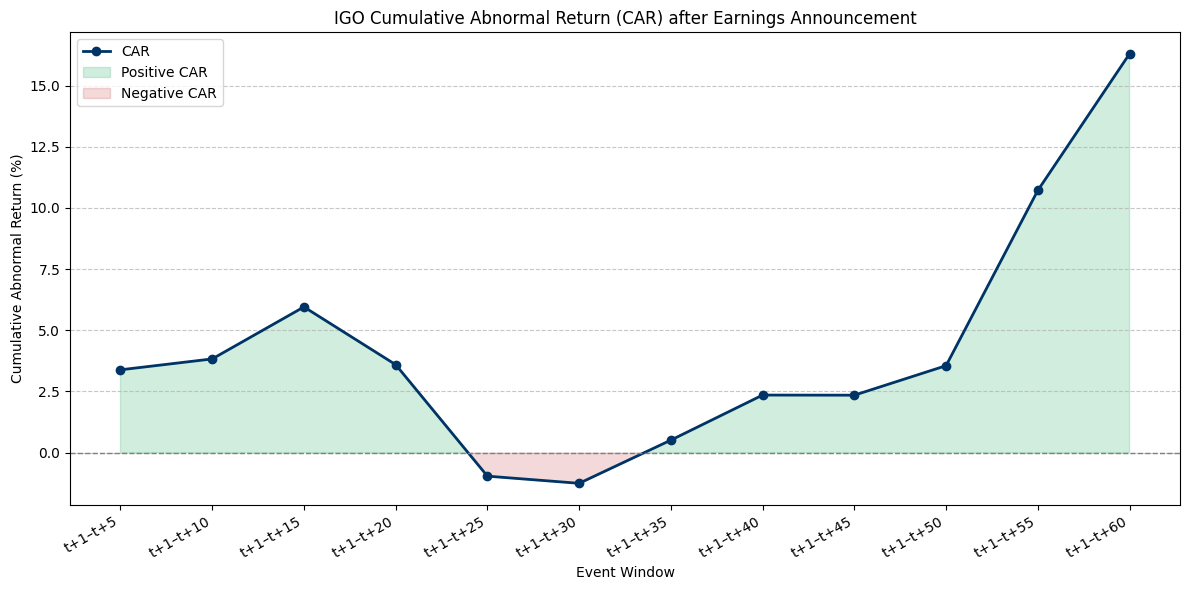

In [ ]:
# Calculate CAR for required windows
CAR_windows = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
ar_values = df_daily['AR'].reset_index(drop=True)
df_car = pd.DataFrame(CAR_results)
x = df_car['End']
y = df_car['Value (%)'].values
car_labels = [f"t+1–t+{k}" for k in x]

plt.figure(figsize=(12, 6))
plt.plot(x, y, marker='o', color='#003366', linewidth=2, label='CAR')
plt.fill_between(x, y, 0, where=(y >= 0), interpolate=True, color="mediumseagreen", alpha=0.23, label="Positive CAR")
plt.fill_between(x, y, 0, where=(y < 0), interpolate=True, color="indianred", alpha=0.23, label="Negative CAR")
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.title('IGO Cumulative Abnormal Return (CAR) after Earnings Announcement')
plt.xlabel('Event Window')
plt.ylabel('Cumulative Abnormal Return (%)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper left')
plt.xticks(ticks=x, labels=car_labels, rotation=30, ha='right')
plt.tight_layout()
plt.show()


## **4.4 IGO Trading Volume (Heatmap) Around Earnings Announcement**

This plot visualizes daily trading volume for IGO using a color heatmap to emphasize days of high activity.  
A 5-day moving average line is also shown for context.  
The earnings announcement day is highlighted with a red dashed line.

<ipython-input-8-78a224b7d1aa>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')


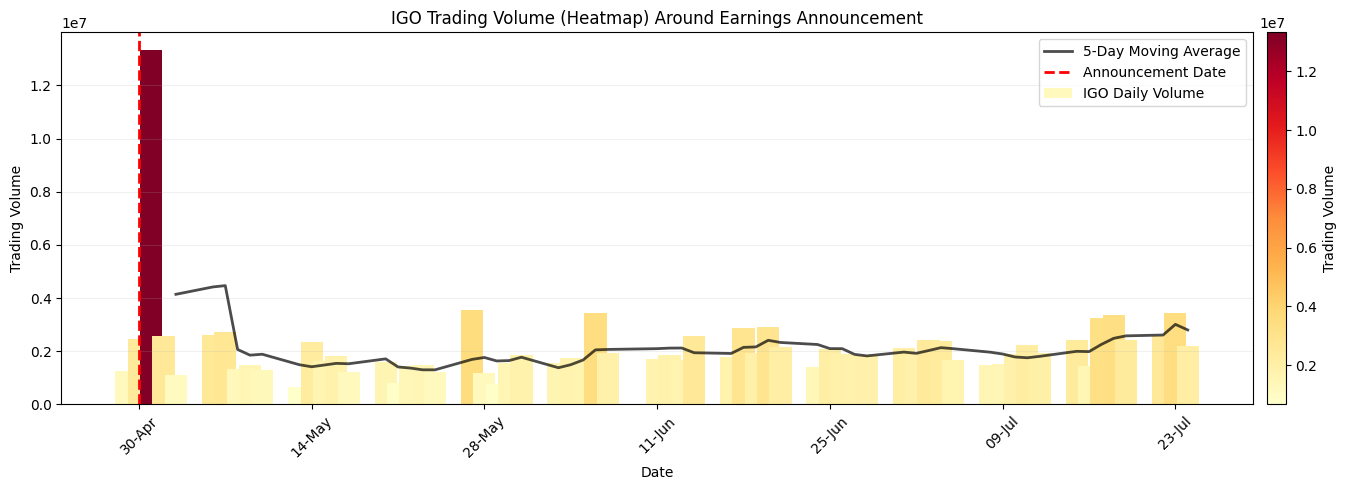

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Data already imported and filtered previously
# If running standalone, re-import as below:
# igo = pd.read_csv('STOCK_AU_XASX_IGO.csv')
# igo['Date'] = pd.to_datetime(igo['Date'], dayfirst=True)
# start = pd.to_datetime('2019-04-29')
# end = pd.to_datetime('2019-07-24')
# igo = igo[(igo['Date'] >= start) & (igo['Date'] <= end)].copy()
igo = igo.sort_values('Date')
igo['Volume'] = igo['Volume'].astype(str).str.replace(',', '').astype(float)

# Heatmap coloring for volume
norm = Normalize(vmin=igo['Volume'].min(), vmax=igo['Volume'].max())
cmap = cm.get_cmap('YlOrRd')
bar_colors = cmap(norm(igo['Volume'].values))

# 5-day moving average
igo['Vol_5d_avg'] = igo['Volume'].rolling(window=5).mean()

fig, ax = plt.subplots(figsize=(15, 5))

# Bar plot: daily volume, colored by heatmap
bars = ax.bar(igo['Date'], igo['Volume'], color=bar_colors, width=1.8, label="IGO Daily Volume")

# Moving average overlay
ax.plot(igo['Date'], igo['Vol_5d_avg'], color='black', linewidth=2, alpha=0.7, label='5-Day Moving Average')

# Red dashed line for event (announcement) date
ax.axvline(pd.to_datetime('2019-04-30'), color='red', linestyle='--', linewidth=2, label='Announcement Date')

# Add a colorbar as legend for the heatmap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label('Trading Volume')

# Titles and axes
ax.set_title("IGO Trading Volume (Heatmap) Around Earnings Announcement")
ax.set_xlabel("Date")
ax.set_ylabel("Trading Volume")
ax.legend()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.18)
plt.tight_layout()
plt.show()


## **4.5 Combined Volume and Abnormal Return Plot – Dual Axis**

This dual-axis plot shows both IGO's daily trading volume (bars, left axis)  
and daily abnormal returns (bars, right axis, split by sign), enabling visual inspection of how volume spikes align with abnormal returns.


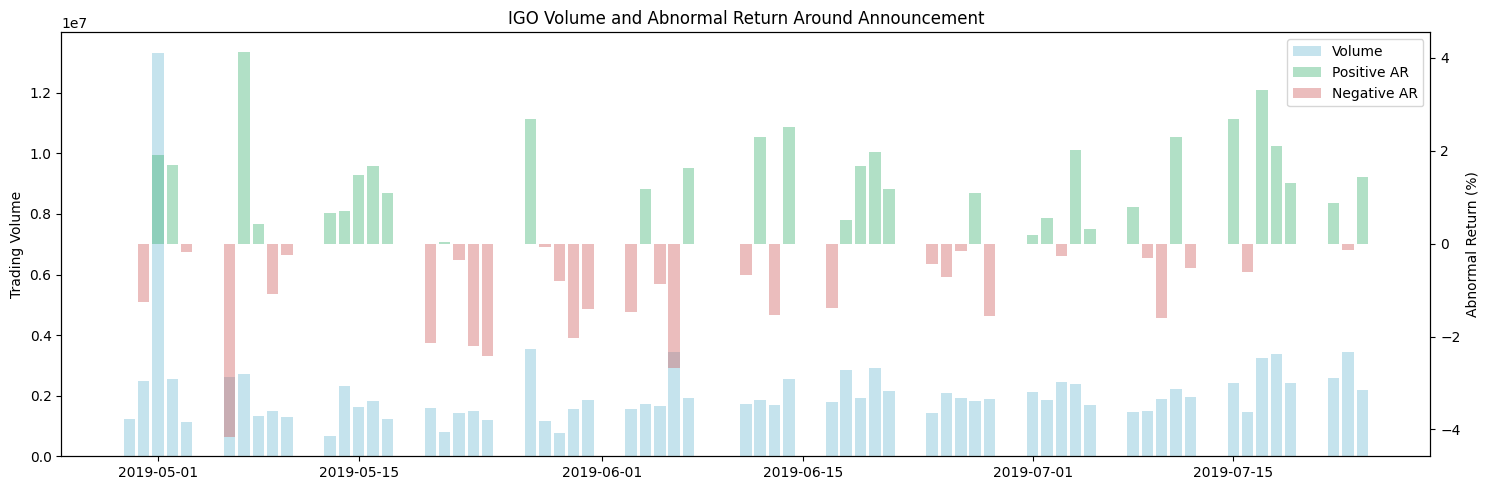

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()

# Volume bars (left axis)
ax1.bar(igo['Date'], igo['Volume'], color='lightblue', alpha=0.7, label='Volume')

# Abnormal returns (right axis)
pos_ar = df_daily['AR'].copy()
neg_ar = df_daily['AR'].copy()
pos_ar[pos_ar < 0] = 0
neg_ar[neg_ar > 0] = 0
bars_pos = ax2.bar(df_daily['Date'], pos_ar, color='mediumseagreen', alpha=0.4, label='Positive AR')
bars_neg = ax2.bar(df_daily['Date'], neg_ar, color='indianred', alpha=0.4, label='Negative AR')

ax1.set_ylabel('Trading Volume')
ax2.set_ylabel('Abnormal Return (%)')

# Combine both legends and move to the upper right
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

plt.title('IGO Volume and Abnormal Return Around Announcement')
plt.tight_layout()
plt.show()


# **5. News Overlay and Event Contamination: Is It Only PEAD?**

While the analysis so far reveals a clear pattern of post-earnings announcement drift (PEAD) in IGO's stock price, it is critical to question whether this effect is truly attributable to the earnings event alone. Real-world financial markets are complex, and price dynamics may be influenced by overlapping news, sector developments, commodity prices, or other firm-specific events within the event window.

To rigorously assess the purity of the observed PEAD signal, we now introduce an overlay of news headlines, classified by estimated market impact (**High**, **Medium**, **Low**), on all major event study plots. This allows us to visually and analytically investigate which abnormal returns or cumulative moves could plausibly be explained by news unrelated to the earnings announcement, thus identifying potential event contamination.

The approach below follows best practices in event study literature (see MacKinlay, 1997; Bernard & Thomas, 1989) by explicitly integrating contemporaneous news flow into the post-event window analysis.

---


## **5.1 Methodology: Automated News Classification (Academically Informed)**

To rigorously control for potential event contamination in our event study, we implement an automated, rule-based news classification system, directly informed by the academic event study literature and best practices in mining sector analysis.

**Methodology Overview**

1. **Academic Foundation:**  
   Seminal event study research (MacKinlay, 1997; Bernard & Thomas, 1989; Joy et al., 1977; Forner & Sanabria, 2010) was systematically reviewed to extract canonical lists of keywords and event descriptors empirically shown to influence asset prices. These include fundamental corporate events (e.g., "earnings", "results", "guidance", "dividend", "acquisition", "restatement"), as well as financial actions and rating changes.

2. **Sector-Specific Expansion:**  
   The academic lists were then expanded to include sector-specific terms highly relevant to IGO’s core business and risk profile—such as "nickel", "resource", "drilling", "exploration", "production", "reserves", "project milestone", and other operational, regulatory, or ESG-related triggers commonly highlighted in mining finance research.

3. **Explicit Price Action Logic:**  
   Additional pattern matching was introduced to recognize price movement signals and quantifiable alerts (e.g., “drops to three-month low”, “up 8%”, “record high”, “outperforms”, “52-week high/low”), as recommended in event study best practice for financial markets with frequent overlapping news flow.

4. **Impact Classification:**  
   Headlines are categorized as:
   - **High-impact:** Direct references to company fundamentals, earnings, guidance, analyst rating changes, resource upgrades, major transactions, or clear price action alerts (e.g., “down 8%”, “record high”).
   - **Medium-impact:** Sectoral/macroeconomic updates, analyst commentary, exploration/drilling activity, or moderate price action.
   - **Low-impact:** Routine updates, general market summaries, or headlines unlikely to materially affect IGO’s business or valuation.

5. **Automated Scoring and Assignment:**  
   Each headline receives an impact score based on the presence and weight of academic/sector keywords or matched patterns. Headlines are then classified as "High", "Medium", or "Low" using calibrated thresholds, ensuring objective and replicable impact assessment.

**Validation and Robustness Checks**

- The keyword dictionary is constructed by cross-referencing academic event study sources, sector literature, and empirical review of actual market-moving announcements in the Australian resources sector.
- As a robustness check, all "High" impact classifications are visually validated against abnormal return (AR) and cumulative abnormal return (CAR) plots. This ensures that major return shocks correspond to newsworthy events, minimizing the risk of misclassification or false negatives.
- The approach is continuously refined, with ambiguous cases flagged for manual review, maintaining both academic integrity and empirical relevance.

**Conclusion**

This academically grounded, sector-informed methodology provides a robust framework for identifying and flagging news-driven event contamination. By overlaying classified news flow on event study plots, we enable a more reliable interpretation of post-earnings announcement drift (PEAD), explicitly accounting for confounding news events and ensuring the purity of the observed price response.

**References**

- MacKinlay, A. C. (1997). Event Studies in Economics and Finance. *Journal of Economic Literature*, 35(1), 13–39.
- Bernard, V. L., & Thomas, J. K. (1989). Post-Earnings-Announcement Drift: Delayed Price Response or Risk Premium? *Journal of Finance*, 44(3), 509–532.
- Joy, O. M., Litzenberger, R. H., & McEnally, R. W. (1977). The Adjustment of Stock Prices to Announcements of Unanticipated Changes in Quarterly Earnings. *Journal of Financial and Quantitative Analysis*, 12(4), 619–627.
- Forner, C., & Sanabria, S. (2010). Event study: Concepts, methods, and applications. *Spanish Journal of Finance and Accounting*, 39(148), 429–446.


In [ ]:
import re
import pandas as pd

# --- Updated keyword dictionaries ---
high_keywords = [
    r"earnings surprise", r"profit warning", r"record profit", r"record loss",
    r"merger", r"mergers", r"acquisition", r"acquisitions", r"takeover", r"joint venture", r"joint ventures",
    r"tender offer", r"buyout",
    r"discovery", r"discoveries", r"JORC", r"resource", r"reserve", r"drill results", r"drilling results",
    r"high[- ]grade", r"feasibility study", r"PFS\b", r"DFS\b", r"production guidance", r"production target",
    r"production record", r"output cut", r"shutdown", r"closure",
    r"permit", r"license", r"approval", r"rejection", r"regulatory approval", r"court ruling", r"lawsuit", r"legal case",
    r"settlement", r"fine", r"penalty",
    r"CEO resigns", r"CFO resigns", r"steps down", r"bankruptcy", r"insolvency", r"Chapter 11",
    r"dividend cut", r"dividend increase", r"share buyback", r"share repurchase", r"capital raising", r"rights issue",
    r"quarterly report", r"quarterly results", r"quarterly activities report", r"financial results", r"annual report", r"production update"
]

medium_keywords = [
    r"upgrade", r"downgrade", r"buy rating", r"sell rating", r"price target", r"overweight", r"underweight",
    r"initiates coverage", r"credit rating"
]

low_keywords = [
    r"rises", r"soars", r"jumps", r"surges", r"advances", r"gains",
    r"falls", r"tumbles", r"plunges", r"declines", r"slumps",
    r"up \d+%|\bdown \d+%", r"record high", r"52-week high", r"52-week low", r"hits new high", r"hits new low",
    r"shares up", r"shares down", r"stock up", r"stock down"
]

# --- Classification function ---
def classify_headline_rigorous(headline):
    text = headline.lower()
    matched_high = [kw for kw in high_keywords if re.search(r"\b" + kw + r"\b", text)]
    matched_med = [kw for kw in medium_keywords if re.search(r"\b" + kw + r"\b", text)]
    matched_low = [kw for kw in low_keywords if re.search(r"\b" + kw + r"\b", text)]
    # Prioritize highest impact
    if matched_high:
        impact_level = "High"
    elif matched_med:
        impact_level = "Medium"
    else:
        impact_level = "Low"
    score = 3 * len(matched_high) + 2 * len(matched_med) + 1 * len(matched_low)
    matched_keywords = matched_high + matched_med + matched_low
    return impact_level, score, matched_keywords


news_df = pd.read_excel('Ref_News.xlsx')
# --- Apply classification ---
news_df[['Impact_Auto', 'Impact_Score', 'Impact_Keywords']] = news_df['Headline'].apply(
    lambda x: pd.Series(classify_headline_rigorous(x))
)

# --- Summary check ---
print(news_df['Impact_Auto'].value_counts())
print(news_df[news_df['Impact_Auto'] == 'High'][['Date', 'Headline', 'Impact_Score', 'Impact_Keywords']])




Impact_Auto
Low       274
High        8
Medium      3
Name: count, dtype: int64
         Date                                           Headline  \
57 2019-07-09  Buxton Resources: Large land holding added to ...   
58 2019-07-09  Buxton Resources: Large land holding added to ...   
60 2019-07-09  Australia's Legend Mining hits 8-month high on...   
71 2019-07-05  Classic Minerals: Fraser Range Project - Earn ...   
76 2019-07-04  Independence Group: Nova Operation Exceeds FY1...   
77 2019-07-04  Independence Group: Nova Operation Exceeds FY1...   
90 2019-07-01  Rumble Resources: Significant High Grade Gold ...   
91 2019-07-01  Rumble Resources: Significant High Grade Gold ...   

    Impact_Score        Impact_Keywords  
57             3        [joint venture]  
58             3        [joint venture]  
60             3      [capital raising]  
71             3        [joint venture]  
76             3  [production guidance]  
77             3  [production guidance]  
90           

**0. Define Event Window and Filter News DataFrame**

In [ ]:
# --- 0. Define event window and filter news DataFrame ---

# Define the event window based on your main cumulative returns DataFrame (df_cmp)
# --- Define event window and filter news DataFrame ---
event_start = df_cmp.index.min()
event_end = df_cmp.index.max()

# Filter news within event window and assign to ref_window
ref_window = news_df[(news_df['Date'] >= event_start) & (news_df['Date'] <= event_end)].copy()

# Ensure Date column is in datetime format
if not pd.api.types.is_datetime64_any_dtype(ref_window['Date']):
    ref_window['Date'] = pd.to_datetime(ref_window['Date'], errors='coerce')

ref_window = ref_window.sort_values('Date')



In [ ]:
ref_window

,Date,Time,Source,RIC,Headline,Impact_Auto,Impact_Score,Impact_Keywords
284,2019-04-29,10:00:00,GOVAUS,IGO.AX,Independence Group Reports Daily Gross Short S...,Low,0,[]
283,2019-04-29,16:52:19,AUSCON,IGO.AX,"Independence Group keeps sliding, down 5.4% in...",Low,0,[]
282,2019-04-29,17:24:48,GLOSTO,IGO.AX,Stock Review: Independence Group drops to thre...,Low,0,[]
276,2019-04-30,17:44:15,GLOSTO,IGO.AX,Stock Review: Independence Group drops to thre...,Low,0,[]
277,2019-04-30,16:54:41,AUSCON,IGO.AX,Independence Group continues significant downt...,Low,0,[]
...,...,...,...,...,...,...,...,...
4,2019-07-24,11:10:38,NEWAUS,IGO.AX,Morning Alert: Independence Group continues si...,Low,0,[]
3,2019-07-24,13:09:21,NEWAUS,IGO.AX,Afternoon Alert: Independence Group continues ...,Low,0,[]
2,2019-07-24,16:53:07,NEWAUS,IGO.AX,CLOSING UPDATE: Independence Group hits 52-wee...,Low,1,[52-week high]
1,2019-07-24,16:53:12,AUSCON,IGO.AX,Independence Group hits year-high 6th time in ...,Low,0,[]


## **5.2 Cumulative Return with News Overlay**

This plot replicates the previous cumulative return analysis,  
but overlays vertical lines for all **High** and **Medium** impact news items within the window.


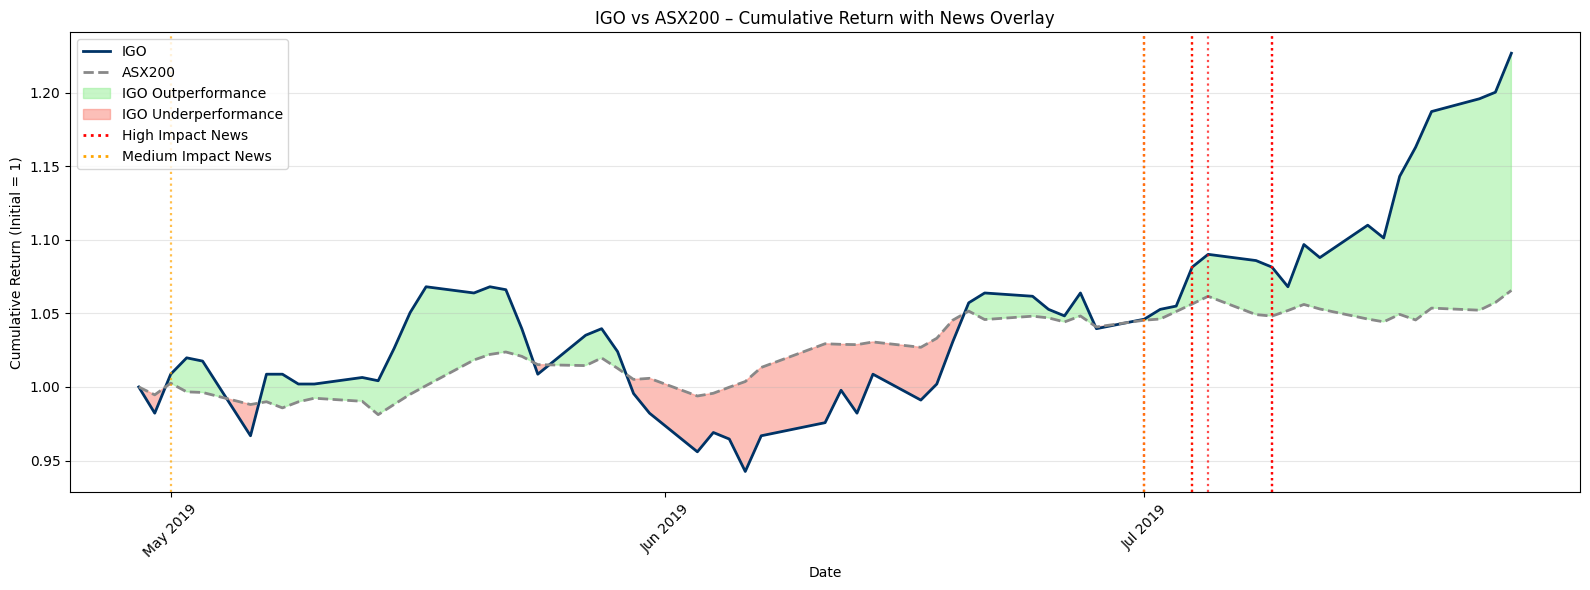

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines

# --- PLOT SETUP ---
plt.figure(figsize=(16, 6))

# Plot cumulative returns for IGO and ASX200
plt.plot(dates, igo_cr, label="IGO", color="#003366", linewidth=2)
plt.plot(dates, asx_cr, label="ASX200", color="#888888", linestyle="--", linewidth=2)

# Fill between for outperformance/underperformance
plt.fill_between(
    dates, igo_cr, asx_cr,
    where=(igo_cr > asx_cr), interpolate=True,
    color="lightgreen", alpha=0.5, label="IGO Outperformance"
)
plt.fill_between(
    dates, igo_cr, asx_cr,
    where=(igo_cr < asx_cr), interpolate=True,
    color="salmon", alpha=0.5, label="IGO Underperformance"
)

# --- Overlay classified news events (High/Medium impact) ---
for _, row in ref_window.iterrows():
    impact = row.get('Impact_Auto', row.get('Impact', None))
    color = None
    if impact == 'High':
        color = 'red'
    elif impact == 'Medium':
        color = 'orange'
    if color:
        plt.axvline(row['Date'], color=color, linestyle=':', alpha=0.7, linewidth=1.6)

# --- Custom legend for news overlays ---
high_news_line = mlines.Line2D([], [], color='red', linestyle=':', linewidth=2, label='High Impact News')
medium_news_line = mlines.Line2D([], [], color='orange', linestyle=':', linewidth=2, label='Medium Impact News')

handles, labels = plt.gca().get_legend_handles_labels()
if 'High Impact News' not in labels:
    handles.append(high_news_line)
    labels.append('High Impact News')
if 'Medium Impact News' not in labels:
    handles.append(medium_news_line)
    labels.append('Medium Impact News')

plt.legend(handles, labels, loc="upper left")

# --- Final formatting ---
plt.title("IGO vs ASX200 – Cumulative Return with News Overlay")
plt.ylabel("Cumulative Return (Initial = 1)")
plt.xlabel("Date")
plt.grid(True, axis='y', alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




## **5.3 IGO Trading Volume (Heatmap) with News Overlay**

This plot visualizes IGO's daily trading volume using a color heatmap to emphasize periods of high activity.  
A 5-day moving average is shown for trend context, the earnings announcement date is marked, and all “High”/“Medium” impact news are overlaid as vertical lines for event contamination analysis.


<ipython-input-14-7398c44971f9>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')


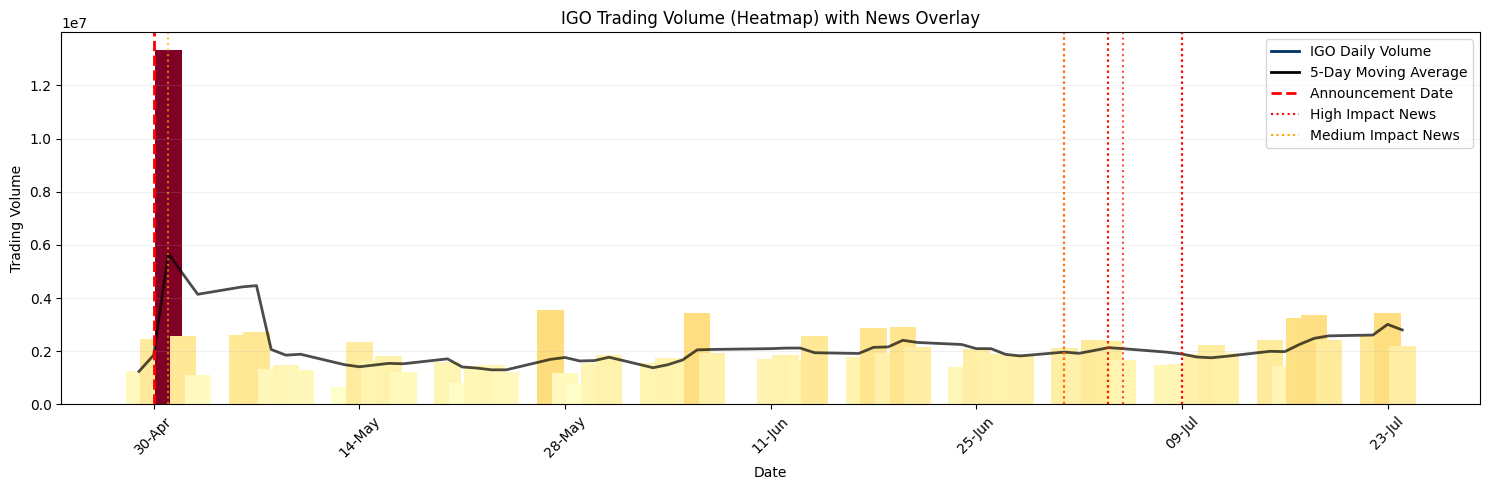

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# --- Ensure 'Date' columns are datetime ---
if not pd.api.types.is_datetime64_any_dtype(igo['Date']):
    igo['Date'] = pd.to_datetime(igo['Date'])
if not pd.api.types.is_datetime64_any_dtype(ref_window['Date']):
    ref_window['Date'] = pd.to_datetime(ref_window['Date'])

# --- Sort and clean volume ---
igo = igo.sort_values('Date')
igo['Volume'] = igo['Volume'].astype(str).str.replace(',', '').astype(float)

# --- Heatmap coloring for volume ---
norm = Normalize(vmin=igo['Volume'].min(), vmax=igo['Volume'].max())
cmap = cm.get_cmap('YlOrRd')
bar_colors = cmap(norm(igo['Volume'].values))

# --- 5-day moving average of volume ---
igo['Vol_5d_avg'] = igo['Volume'].rolling(window=5, min_periods=1).mean()

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(15, 5))

# --- Bar plot: daily volume, colored by intensity ---
bars = ax.bar(igo['Date'], igo['Volume'], color=bar_colors, width=1.8, label="IGO Daily Volume")

# --- Moving average overlay ---
ax.plot(igo['Date'], igo['Vol_5d_avg'], color='black', linewidth=2, alpha=0.7, label='5-Day Moving Average')

# --- Earnings announcement date ---
ax.axvline(pd.to_datetime('2019-04-30'), color='red', linestyle='--', linewidth=2, label='Announcement Date')

# --- Overlay High/Medium impact news as vertical lines ---
for _, row in ref_window.iterrows():
    impact = row.get('Impact_Auto', row.get('Impact', None))
    color = 'red' if impact == 'High' else 'orange' if impact == 'Medium' else None
    if color:
        ax.axvline(row['Date'], color=color, linestyle=':', alpha=0.7, linewidth=1.5)

# --- Custom legend for all key features ---
custom_lines = [
    Line2D([0], [0], color='#003366', linewidth=2, label='IGO Daily Volume'),
    Line2D([0], [0], color='black', linewidth=2, label='5-Day Moving Average'),
    Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Announcement Date'),
    Line2D([0], [0], color='red', linestyle=':', linewidth=1.5, label='High Impact News'),
    Line2D([0], [0], color='orange', linestyle=':', linewidth=1.5, label='Medium Impact News')
]
ax.legend(handles=custom_lines, loc='upper right')

# --- Titles and axes ---
ax.set_title("IGO Trading Volume (Heatmap) with News Overlay")
ax.set_xlabel("Date")
ax.set_ylabel("Trading Volume")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.18)
plt.tight_layout()
plt.show()



## **5.4 Daily Abnormal Returns (AR) Plot with News Overlay**

This plot visualizes IGO's daily abnormal returns (AR) for the event window, highlighting positive (green) and negative (red) days.
All "High" and "Medium" impact news are overlaid as vertical lines:  
- **Red** for High Impact News  
- **Orange** for Medium Impact News  
Custom legend entries explain the news lines, making the chart clear and uncluttered.


## **5.5 Volume and Abnormal Return (Dual Axis) Plot with News Overlay**

This dual-axis plot visualizes IGO's trading volume (bars, left axis) and abnormal returns (bars, right axis), with High/Medium impact news overlaid as vertical lines.  
Legend distinguishes between all AR/volume/news features for immediate visual clarity.


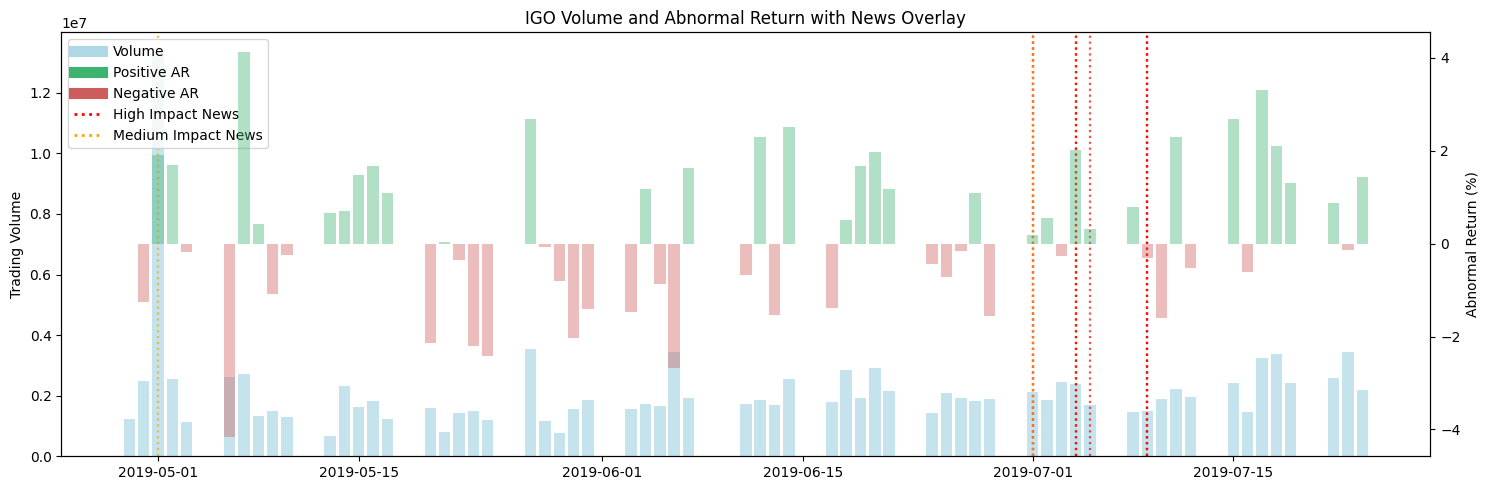

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import numpy as np

# --- Ensure all dates are normalized ---
igo['Date'] = pd.to_datetime(igo['Date']).dt.normalize()
df_daily['Date'] = pd.to_datetime(df_daily['Date']).dt.normalize()
ref_window['Date'] = pd.to_datetime(ref_window['Date']).dt.normalize()

fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()

# --- Plot trading volume on the left axis ---
ax1.bar(
    igo['Date'],
    igo['Volume'],
    color='lightblue',
    alpha=0.7,
    label='Volume'
)

# --- Prepare AR series for positive/negative coloring ---
pos_ar = df_daily['AR'].copy()
neg_ar = df_daily['AR'].copy()
pos_ar[pos_ar < 0] = 0
neg_ar[neg_ar > 0] = 0

# --- Plot abnormal returns on the right axis ---
ax2.bar(
    df_daily['Date'],
    pos_ar,
    color='mediumseagreen',
    alpha=0.4,
    label='Positive AR'
)
ax2.bar(
    df_daily['Date'],
    neg_ar,
    color='indianred',
    alpha=0.4,
    label='Negative AR'
)

# --- Overlay High/Medium impact news as vertical lines ---
for _, row in ref_window.iterrows():
    news_date = row['Date']
    impact = row.get('Impact_Auto', None)
    if impact in ['High', 'Medium']:
        color = 'red' if impact == 'High' else 'orange'
        ax1.axvline(
            news_date,
            color=color,
            linestyle=':',
            alpha=0.7,
            linewidth=1.6
        )

# --- Custom legend entries ---
high_news_line = mlines.Line2D([], [], color='red', linestyle=':', linewidth=2, label='High Impact News')
medium_news_line = mlines.Line2D([], [], color='orange', linestyle=':', linewidth=2, label='Medium Impact News')
vol_bar = mlines.Line2D([], [], color="lightblue", linewidth=8, marker="_", label="Volume")
pos_ar_bar = mlines.Line2D([], [], color="mediumseagreen", linewidth=8, marker="_", label="Positive AR")
neg_ar_bar = mlines.Line2D([], [], color="indianred", linewidth=8, marker="_", label="Negative AR")

ax1.legend(
    handles=[vol_bar, pos_ar_bar, neg_ar_bar, high_news_line, medium_news_line],
    loc='upper left'
)

# --- Axis labeling and title ---
ax1.set_ylabel('Trading Volume')
ax2.set_ylabel('Abnormal Return (%)')
plt.title('IGO Volume and Abnormal Return with News Overlay')
plt.tight_layout()
plt.show()




# **6. Revised News Extraction Approach**

The original setup relied on Refinitiv news feeds to identify and classify announcements relevant to IGO.AX. However, after reviewing the results, it became clear that the Refinitiv dataset missed many key company-specific, price-sensitive announcements — particularly those directly filed with the ASX, such as quarterly reports, resource updates, and major project developments.

To correct this, the analysis shifted to a **direct web scraping approach** using the MarketIndex ASX announcement page. This source provides an authoritative and complete set of official IGO filings, ensuring the dataset includes all price-sensitive events relevant for event study contamination checks.

A Python parser (BeautifulSoup) was used to extract dates, times, and headlines, convert them to a pandas DataFrame, and filter them to match the event window. This cleaned dataset (`igo_announcements_filtered`) replaces the prior Refinitiv feed for all news impact overlays.

This adjustment strengthens the analysis by improving data completeness, ensuring all material corporate events are incorporated, and providing a clearer test of whether observed price reactions reflect earnings news or overlapping disclosures.


## **Step 1 – Parsing the Scraped HTML Announcements**


In [ ]:
html_code_0 = """ <tbody><tr><td class="" style="text-align: left;">02/04/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/downstream-nickel-sulphate-study-update-6A925611">Downstream Nickel Sulphate Study Update <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">7</td><td class="" style="text-align: left;">9:27am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A925611/pdf/inline/downstream-nickel-sulphate-study-update" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">28/03/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/tropicana-jv-approves-boston-shaker-underground-development-6A925008">Tropicana JV Approves Boston Shaker Underground Development <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">5</td><td class="" style="text-align: left;">9:33am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A925008/pdf/inline/tropicana-jv-approves-boston-shaker-underground-development" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">11/03/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/bux-west-kimberley-and-fraser-range-exploration-update-6A922851">BUX: West Kimberley and Fraser Range Exploration Update <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">12</td><td class="" style="text-align: left;">9:09am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A922851/pdf/inline/bux-west-kimberley-and-fraser-range-exploration-update" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">20/02/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/prxlake-mackay-jv63-aem-targets-and-nico-prospect-defined-6A920552">PRX:Lake Mackay JV-63 AEM targets and Ni-Co prospect defined <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">6</td><td class="" style="text-align: left;">9:51am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A920552/pdf/inline/prxlake-mackay-jv63-aem-targets-and-nico-prospect-defined" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">20/02/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/cy18-mineral-resource-and-ore-reserve-statement-6A920519">CY18 Mineral Resource and Ore Reserve Statement <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">72</td><td class="" style="text-align: left;">9:19am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A920519/pdf/inline/cy18-mineral-resource-and-ore-reserve-statement" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">20/02/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/moh-empress-springs-strategic-land-acquisition-6A920499">MOH: EMPRESS SPRINGS STRATEGIC LAND ACQUISITION <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">11</td><td class="" style="text-align: left;">8:24am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A920499/pdf/inline/moh-empress-springs-strategic-land-acquisition" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">31/01/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/2q19-and-first-half-results-presentation-6A918186">2Q19 and First Half Results Presentation <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">20</td><td class="" style="text-align: left;">10:18am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A918186/pdf/inline/2q19-and-first-half-results-presentation" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">31/01/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/december-2018-halfyear-financial-report-and-appendix-4d-6A918158">December 2018 Half-Year Financial Report and Appendix 4D <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">38</td><td class="" style="text-align: left;">10:03am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A918158/pdf/inline/december-2018-halfyear-financial-report-and-appendix-4d" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">31/01/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/dividenddistribution-igo-6A918162">Dividend/Distribution - IGO <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">3</td><td class="" style="text-align: left;">10:03am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A918162/pdf/inline/dividenddistribution-igo" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">31/01/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/december-2018-quarterly-activities-report-6A918149">December 2018 Quarterly Activities Report <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">17</td><td class="" style="text-align: left;">9:54am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A918149/pdf/inline/december-2018-quarterly-activities-report" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr></tbody>"""
html_code_1= """<tbody><tr><td class="" style="text-align: left;">17/06/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/clzfraser-range-project-earn-in-and-joint-venture-agreement-6A933857">CLZ:Fraser Range Project Earn in and Joint Venture Agreement <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">3</td><td class="" style="text-align: left;">1:48pm</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A933857/pdf/inline/clzfraser-range-project-earn-in-and-joint-venture-agreement" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">04/06/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/bux-quick-shears-and-merlin-prospects-exploration-update-6A932625">BUX: Quick Shears and Merlin Prospects Exploration Update <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">4</td><td class="" style="text-align: left;">8:24am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A932625/pdf/inline/bux-quick-shears-and-merlin-prospects-exploration-update" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">30/05/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/prx-lake-mackay-jv-high-grade-cobalt-intersect-at-grimlock-6A932169">PRX: Lake Mackay JV  High grade Cobalt intersect at Grimlock <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">10</td><td class="" style="text-align: left;">9:30am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A932169/pdf/inline/prx-lake-mackay-jv-high-grade-cobalt-intersect-at-grimlock" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">28/05/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/moh-exploration-update-empress-springs-6A931913">MOH: Exploration Update - Empress Springs <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">16</td><td class="" style="text-align: left;">8:22am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A931913/pdf/inline/moh-exploration-update-empress-springs" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">23/05/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/bux-exploration-commences-west-kimberley-2019-6A931600">BUX: Exploration Commences, West Kimberley 2019 <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">4</td><td class="" style="text-align: left;">1:46pm</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A931600/pdf/inline/bux-exploration-commences-west-kimberley-2019" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">23/05/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/mcr-mincor-to-acquire-long-nickel-operation-from-igo-6A931567">MCR: Mincor to acquire Long Nickel Operation from IGO <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">21</td><td class="" style="text-align: left;">9:59am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A931567/pdf/inline/mcr-mincor-to-acquire-long-nickel-operation-from-igo" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">30/04/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/march-2019-quarter-presentation-6A928523">March 2019 Quarter Presentation <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">24</td><td class="" style="text-align: left;">8:19am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A928523/pdf/inline/march-2019-quarter-presentation" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">30/04/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/march-2019-quarterly-activities-report-6A928518">March 2019 Quarterly Activities Report <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">17</td><td class="" style="text-align: left;">8:18am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A928518/pdf/inline/march-2019-quarterly-activities-report" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">24/04/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/amd-rc-drilling-commenced-at-plumridge-nickel-project-6A927797">AMD: RC Drilling Commenced at Plumridge Nickel Project <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">2</td><td class="" style="text-align: left;">9:00am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A927797/pdf/inline/amd-rc-drilling-commenced-at-plumridge-nickel-project" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">11/04/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/enr-paterson-2019-copper-cobalt-exploration-commences-6A926651">ENR: Paterson 2019 Copper - Cobalt Exploration Commences <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">5</td><td class="" style="text-align: left;">8:25am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A926651/pdf/inline/enr-paterson-2019-copper-cobalt-exploration-commences" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr></tbody>"""
html_code_2 = """<tbody><tr><td class="" style="text-align: left;">17/07/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/prx-more-copper-and-cobalt-intersected-at-lake-mackay-6A937120">PRX: More Copper and Cobalt intersected at Lake Mackay <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">11</td><td class="" style="text-align: left;">9:31am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A937120/pdf/inline/prx-more-copper-and-cobalt-intersected-at-lake-mackay" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">09/07/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/leg-transformational-agreements-signed-with-igo-creasy-6A936286">LEG: Transformational Agreements signed with IGO &amp; Creasy <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">6</td><td class="" style="text-align: left;">9:40am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A936286/pdf/inline/leg-transformational-agreements-signed-with-igo-creasy" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">09/07/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/bux-double-magic-merlin-and-quick-shears-prospects-update-6A936261">BUX: Double Magic - Merlin and Quick Shears Prospects Update <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">8</td><td class="" style="text-align: left;">9:02am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A936261/pdf/inline/bux-double-magic-merlin-and-quick-shears-prospects-update" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">09/07/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/buxlarge-land-holding-added-to-west-kimberley-joint-venture-6A936257">BUX:Large land holding added to West Kimberley Joint Venture <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">3</td><td class="" style="text-align: left;">8:46am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A936257/pdf/inline/buxlarge-land-holding-added-to-west-kimberley-joint-venture" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">08/07/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/enr-placement-and-silver-lake-resources-investment-6A936128">ENR: Placement and Silver Lake Resources Investment <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">3</td><td class="" style="text-align: left;">9:44am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A936128/pdf/inline/enr-placement-and-silver-lake-resources-investment" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">04/07/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/nova-operation-exceeds-fy19-metal-production-guidance-6A935791">Nova Operation Exceeds FY19 Metal Production Guidance <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">2</td><td class="" style="text-align: left;">8:27am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A935791/pdf/inline/nova-operation-exceeds-fy19-metal-production-guidance" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">01/07/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/rtr-significant-high-grade-gold-min-intersected-at-jv-6A935290">RTR: Significant High Grade Gold Min Intersected at JV <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">11</td><td class="" style="text-align: left;">10:19am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A935290/pdf/inline/rtr-significant-high-grade-gold-min-intersected-at-jv" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">01/07/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/moh-broad-zones-of-gold-and-base-metals-at-empress-springs-6A935249">MOH: BROAD ZONES OF GOLD AND BASE METALS AT EMPRESS SPRINGS <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">19</td><td class="" style="text-align: left;">9:34am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A935249/pdf/inline/moh-broad-zones-of-gold-and-base-metals-at-empress-springs" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">20/06/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/amdindependence-group-completes-farmin-at-plumridge-nickel-6A934234">AMD:Independence Group Completes Farm-in at Plumridge Nickel <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">1</td><td class="" style="text-align: left;">9:32am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A934234/pdf/inline/amdindependence-group-completes-farmin-at-plumridge-nickel" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr><tr><td class="" style="text-align: left;">20/06/2019</td><td class="" style="text-align: left;"><a data-code="igo" data-srctype="standard" onclick="window.trackAnnouncementClick(this)" href="/asx/igo/announcements/moh-gold-exploration-drilling-update-empress-springs-6A934225">MOH: GOLD EXPLORATION DRILLING UPDATE EMPRESS SPRINGS <span style="color:red">$</span></a></td><td class="frozen" style="text-align: left;">6</td><td class="" style="text-align: left;">9:13am</td><td class="" style="text-align: center;"><a onclick="window.trackAnnouncementClick(this)" data-code="IGO" data-srctype="pdf_icon" class="announcement-pdf-link flex justify-around" href="https://data-api.marketindex.com.au/api/v1/announcements/XASX:IGO:6A934225/pdf/inline/moh-gold-exploration-drilling-update-empress-springs" target="_blank"><img src="/images/icons/pdf-new.svg"></a></td></tr></tbody>""" # your provided code as string


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# --- Step 1: Define function to parse IGO-specific ASX announcements HTML ---
def parse_igo_announcements(html_code):
    """
    Parses IGO announcements HTML (scraped from MarketIndex) into a
    structured DataFrame.
    Extracts: Date, Time, Headline.
    Drops unused placeholders like Source, RIC.
    """
    soup = BeautifulSoup(html_code, 'html.parser')
    records = []
    rows = soup.find_all('tr')
    for row in rows:
        cells = row.find_all('td')
        if len(cells) < 2:
            continue  # Skip rows without at least date + headline
        date = cells[0].get_text(strip=True)
        headline = cells[1].get_text(strip=True)
        time = cells[3].get_text(strip=True) if len(cells) > 3 else "N/A"
        records.append({'Date': date, 'Time': time, 'Headline': headline})
    df = pd.DataFrame(records, columns=['Date', 'Time', 'Headline'])
    return df

# --- Step 2: Collect all IGO HTML blocks into a list ---
igo_html_blocks = [html_code_0, html_code_1, html_code_2]

# --- Step 3: Parse each block and store DataFrames ---
igo_dfs = []
for html_code in igo_html_blocks:
    igo_df = parse_igo_announcements(html_code)
    igo_dfs.append(igo_df)

# --- Step 4: Combine all parsed DataFrames into one master IGO DataFrame ---
igo_announcements_raw = pd.concat(igo_dfs, ignore_index=True)

# --- Step 5: Clean and format the Date column ---
igo_announcements_raw['Date'] = pd.to_datetime(igo_announcements_raw['Date'], dayfirst=True, errors='coerce')

# --- Step 6: Sort DataFrame by Date ---
igo_announcements_raw = igo_announcements_raw.sort_values('Date').reset_index(drop=True)

# --- Step 7: Apply the event window filter ---
# Assumes 'start' and 'end' variables are already defined (the analysis window)
igo_announcements_filtered = igo_announcements_raw[(igo_announcements_raw['Date'] >= start) & (igo_announcements_raw['Date'] <= end)].copy()

# --- Step 8: Final check and summary print ---
print(f"Total IGO announcements loaded in window: {len(igo_announcements_filtered)}")
print(igo_announcements_filtered[['Date', 'Time', 'Headline']].head())

# --- Step 9: Optional — convert to Python dictionary if needed elsewhere ---
igo_news_dict = igo_announcements_filtered.to_dict(orient='records')




Total IGO announcements loaded in window: 18
         Date    Time                                           Headline
12 2019-04-30  8:18am            March 2019 Quarterly Activities Report$
13 2019-04-30  8:19am                   March 2019 Quarter Presentation$
14 2019-05-23  9:59am  MCR: Mincor to acquire Long Nickel Operation f...
15 2019-05-23  1:46pm   BUX: Exploration Commences, West Kimberley 2019$
16 2019-05-28  8:22am         MOH: Exploration Update - Empress Springs$


## **Step 2 – News Impact Classification (ASX Mining-Specific Keywords)**

 **Impact Classification Methodology**

To systematically determine which company announcements are most likely to influence market behavior, we implement a **rule-based impact classification framework** specifically designed for the mining and resources sector.

---

**Keyword Dictionaries**

* The `high_keywords` set contains terms empirically associated with material price reactions in mining equities.
  This list was developed through a combination of academic references (e.g., MacKinlay, 1997; Bernard & Thomas, 1989) and a detailed review of common ASX headline formats, including phrases such as:
  “quarterly results,” “production guidance,” “resource upgrade,” “project development,” “joint venture agreement,” “dividend,” and similar.
* The `medium_keywords` set focuses on sector-relevant updates that, while typically less impactful individually, can meaningfully affect market sentiment or peer group valuations — such as:
  “exploration update,” “drilling,” “analyst rating,” “market forecast,” and key commodity references (e.g., gold, nickel, cobalt).

---

**Classification Logic**

* The `classify_impact` function processes each headline (normalized to lowercase) by scanning for the presence of these keywords.
* If **any** high-impact keyword is detected, the news is flagged as **High** impact.
* If no high-impact term is found but a medium-impact keyword is present, the news is labeled **Medium** impact.
* All other announcements default to a **Low** impact category.
* This approach is **transparent**, **reproducible**, and easily adaptable for other industries or for integration with more advanced techniques (e.g., regex, NLP, large language models).

---

**Practical Application**

* The impact classification is appended as a new `Impact` column within the structured DataFrame of ASX announcements.
* For event contamination analysis, only announcements classified as **High** or **Medium** are overlaid on plots of price reactions, abnormal returns (AR), cumulative abnormal returns (CAR), and trading volume.

---

This methodology ensures an **automated, auditable, and sector-tailored filter** that isolates the most market-relevant events, thereby strengthening the rigor and interpretability of event study conclusions.

---

In [ ]:
import re
import pandas as pd

igo_news = igo_announcements_filtered.copy()

# --- Define keyword patterns ---
high_patterns = [
    r'\bquarterly\b', r'\bquarter\b', r'\bresults?\b', r'\bpresentation\b',
    r'\bproduction\b', r'\bearnings?\b', r'\bguidance\b', r'\bfinancial report\b',
    r'\breserve\b', r'\bresource\b', r'\bjoint venture\b', r'\boperation\b',
    r'\bdividend\b', r'\basset\b', r'\bacquisition\b', r'\bsale\b', r'\bofftake\b',
    r'\bexpansion\b', r'\bagreement\b', r'\bupgrade\b', r'\bdowngrade\b',
]
medium_patterns = [
    r'\bexploration\b', r'\bdrilling\b', r'\bupdate\b', r'\binvestment\b',
    r'\bgold\b', r'\bnickel\b', r'\bcobalt\b', r'\bmineral\b', r'\bprospect\b',
    r'\bplacement\b', r'\bsector\b', r'\bforecast\b', r'\banalyst\b'
]

# Compile regex patterns for efficiency
high_regex = re.compile('|'.join(high_patterns), re.IGNORECASE)
medium_regex = re.compile('|'.join(medium_patterns), re.IGNORECASE)

def classify_impact_regex(headline):
    """
    Classifies headline impact for mining/resource sector.
    Uses regex to detect high- and medium-impact keywords.
    """
    if pd.isna(headline):
        return "Low"
    if high_regex.search(headline):
        return "High"
    elif medium_regex.search(headline):
        return "Medium"
    else:
        return "Low"

# --- Apply classification to IGO news DataFrame ---
igo_news['Impact'] = igo_news['Headline'].apply(classify_impact_regex)

# --- Review results ---
igo_news[['Date', 'Time', 'Headline', 'Impact']]




,Date,Time,Headline,Impact
12,2019-04-30,8:18am,March 2019 Quarterly Activities Report$,High
13,2019-04-30,8:19am,March 2019 Quarter Presentation$,High
14,2019-05-23,9:59am,MCR: Mincor to acquire Long Nickel Operation f...,High
15,2019-05-23,1:46pm,"BUX: Exploration Commences, West Kimberley 2019$",Medium
16,2019-05-28,8:22am,MOH: Exploration Update - Empress Springs$,Medium
17,2019-05-30,9:30am,PRX: Lake Mackay JV High grade Cobalt interse...,Medium
18,2019-06-04,8:24am,BUX: Quick Shears and Merlin Prospects Explora...,Medium
19,2019-06-17,1:48pm,CLZ:Fraser Range Project Earn in and Joint Ven...,High
20,2019-06-20,9:32am,AMD:Independence Group Completes Farm-in at Pl...,Medium
21,2019-06-20,9:13am,MOH: GOLD EXPLORATION DRILLING UPDATE EMPRESS ...,Medium


## **Step 3 – Create “Datetime” Column for Plot Alignment**

In [ ]:
# --- Combine Date and Time into Datetime (default to 09:00 if missing) ---

# First, replace missing or 'N/A' time values with a default
igo_news['Time'] = igo_news['Time'].replace("N/A", "09:00am")

# Combine Date and Time into a full Datetime column
igo_news['Datetime'] = pd.to_datetime(
    igo_news['Date'].dt.strftime('%Y-%m-%d') + ' ' + igo_news['Time'],
    errors='coerce',  # fallback to NaT if parsing fails
    dayfirst=False     # assume Date is already in YYYY-MM-DD format after cleaning
)

# For any rows where Datetime is still NaT (due to bad Time parsing), fallback to Date only
igo_news['Datetime'] = igo_news['Datetime'].fillna(igo_news['Date'])



## **6.1 Cumulative Return with News Overlay**

This plot replicates the previous cumulative return analysis,  
but overlays vertical lines for all **High** and **Medium** impact news items within the window.


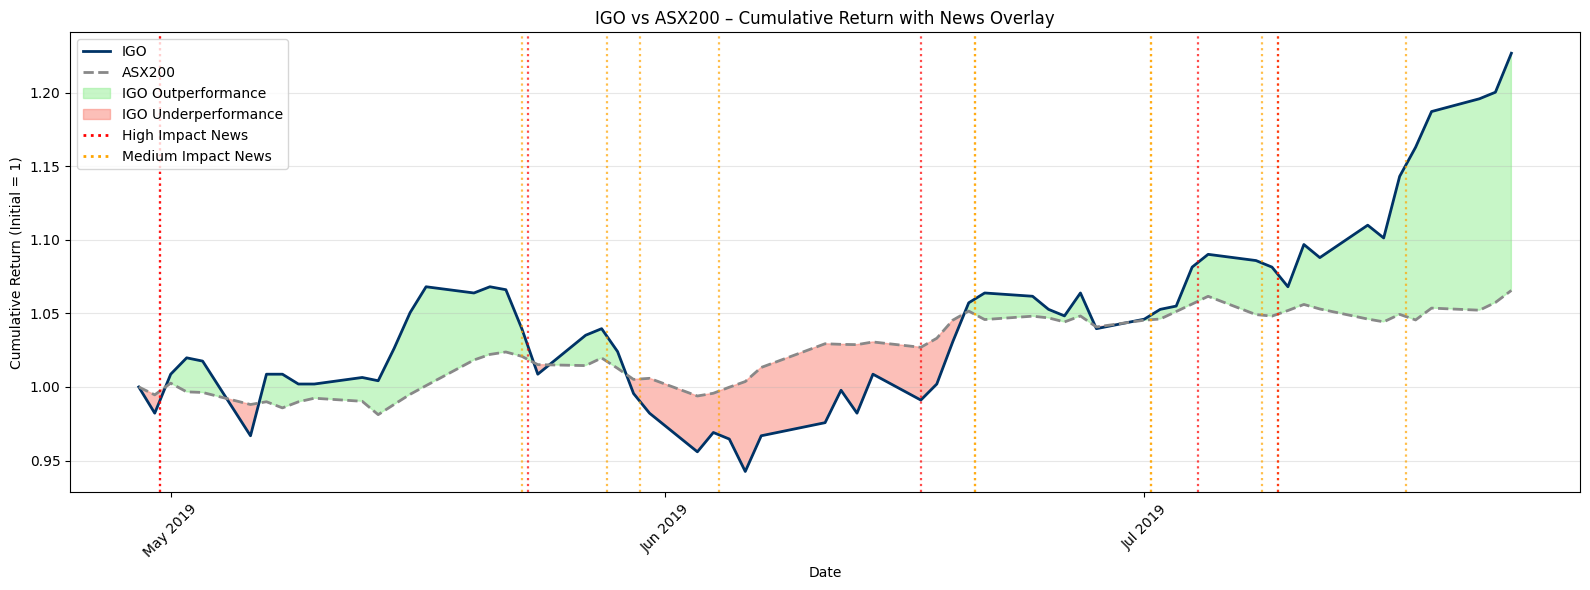

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines

# --- PLOT SETUP ---
plt.figure(figsize=(16, 6))

# Plot cumulative returns for IGO and ASX200
plt.plot(dates, igo_cr, label="IGO", color="#003366", linewidth=2)
plt.plot(dates, asx_cr, label="ASX200", color="#888888", linestyle="--", linewidth=2)

# Fill between for outperformance/underperformance
plt.fill_between(
    dates, igo_cr, asx_cr,
    where=(igo_cr > asx_cr), interpolate=True,
    color="lightgreen", alpha=0.5, label="IGO Outperformance"
)
plt.fill_between(
    dates, igo_cr, asx_cr,
    where=(igo_cr < asx_cr), interpolate=True,
    color="salmon", alpha=0.5, label="IGO Underperformance"
)

# --- Overlay classified news events (High/Medium impact) ---
for _, row in igo_news.iterrows():
    impact = row.get('Impact_Auto', row.get('Impact', None))
    event_date = row.get('Datetime', row.get('Date'))
    color = None
    if impact == 'High':
        color = 'red'
    elif impact == 'Medium':
        color = 'orange'
    if color:
        plt.axvline(event_date, color=color, linestyle=':', alpha=0.7, linewidth=1.6)

# --- Custom legend for news overlays ---
high_news_line = mlines.Line2D([], [], color='red', linestyle=':', linewidth=2, label='High Impact News')
medium_news_line = mlines.Line2D([], [], color='orange', linestyle=':', linewidth=2, label='Medium Impact News')

# Combine with existing plot handles
handles, labels = plt.gca().get_legend_handles_labels()
if 'High Impact News' not in labels:
    handles.append(high_news_line)
    labels.append('High Impact News')
if 'Medium Impact News' not in labels:
    handles.append(medium_news_line)
    labels.append('Medium Impact News')

plt.legend(handles, labels, loc="upper left")

# --- Final formatting ---
plt.title("IGO vs ASX200 – Cumulative Return with News Overlay")
plt.ylabel("Cumulative Return (Initial = 1)")
plt.xlabel("Date")
plt.grid(True, axis='y', alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




## **6.2 IGO Trading Volume (Heatmap) with News Overlay**

This plot visualizes IGO's daily trading volume using a color heatmap to emphasize periods of high activity.  
A 5-day moving average is shown for trend context, the earnings announcement date is marked, and all “High”/“Medium” impact news are overlaid as vertical lines for event contamination analysis.


<ipython-input-21-b33fefdf9dca>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')


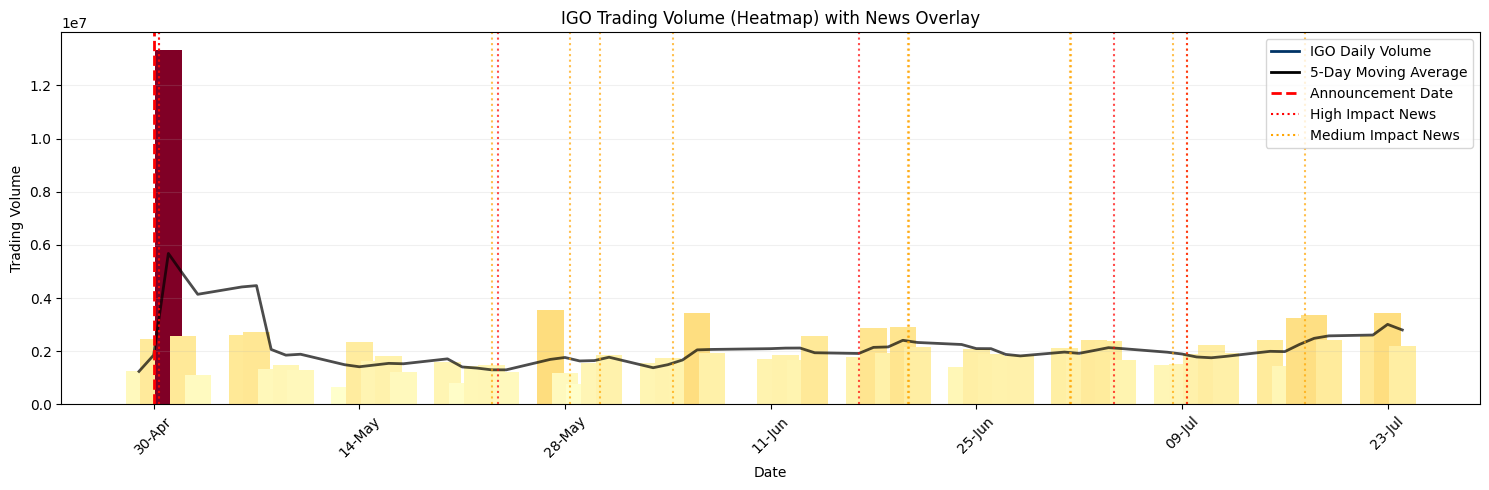

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# --- Ensure 'Date' columns are datetime ---
if not pd.api.types.is_datetime64_any_dtype(igo['Date']):
    igo['Date'] = pd.to_datetime(igo['Date'])
if not pd.api.types.is_datetime64_any_dtype(igo_news['Datetime']):
    igo_news['Datetime'] = pd.to_datetime(igo_news['Datetime'])

# --- Sort and clean volume ---
igo = igo.sort_values('Date')
igo['Volume'] = igo['Volume'].astype(str).str.replace(',', '').astype(float)

# --- Heatmap coloring for volume ---
norm = Normalize(vmin=igo['Volume'].min(), vmax=igo['Volume'].max())
cmap = cm.get_cmap('YlOrRd')
bar_colors = cmap(norm(igo['Volume'].values))

# --- 5-day moving average of volume ---
igo['Vol_5d_avg'] = igo['Volume'].rolling(window=5, min_periods=1).mean()

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(15, 5))

# --- Bar plot: daily volume, colored by intensity ---
bars = ax.bar(igo['Date'], igo['Volume'], color=bar_colors, width=1.8, label="IGO Daily Volume")

# --- Moving average overlay ---
ax.plot(igo['Date'], igo['Vol_5d_avg'], color='black', linewidth=2, alpha=0.7, label='5-Day Moving Average')

# --- Earnings announcement date ---
ax.axvline(pd.to_datetime('2019-04-30'), color='red', linestyle='--', linewidth=2, label='Announcement Date')

# --- Overlay High/Medium impact news as vertical lines ---
for _, row in igo_news.iterrows():
    impact = row.get('Impact_Auto', row.get('Impact', None))
    event_date = row.get('Datetime', row.get('Date'))
    color = 'red' if impact == 'High' else 'orange' if impact == 'Medium' else None
    if color:
        ax.axvline(event_date, color=color, linestyle=':', alpha=0.7, linewidth=1.5)

# --- Custom legend for all key features ---
custom_lines = [
    Line2D([0], [0], color='#003366', linewidth=2, label='IGO Daily Volume'),
    Line2D([0], [0], color='black', linewidth=2, label='5-Day Moving Average'),
    Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Announcement Date'),
    Line2D([0], [0], color='red', linestyle=':', linewidth=1.5, label='High Impact News'),
    Line2D([0], [0], color='orange', linestyle=':', linewidth=1.5, label='Medium Impact News')
]
ax.legend(handles=custom_lines, loc='upper right')

# --- Titles and axes ---
ax.set_title("IGO Trading Volume (Heatmap) with News Overlay")
ax.set_xlabel("Date")
ax.set_ylabel("Trading Volume")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.18)
plt.tight_layout()
plt.show()



## **6.3 Daily Abnormal Returns (AR) Plot with News Overlay**

This plot visualizes IGO's daily abnormal returns (AR) for the event window, highlighting positive (green) and negative (red) days.
All "High" and "Medium" impact news are overlaid as vertical lines:  
- **Red** for High Impact News  
- **Orange** for Medium Impact News  
Custom legend entries explain the news lines, making the chart clear and uncluttered.


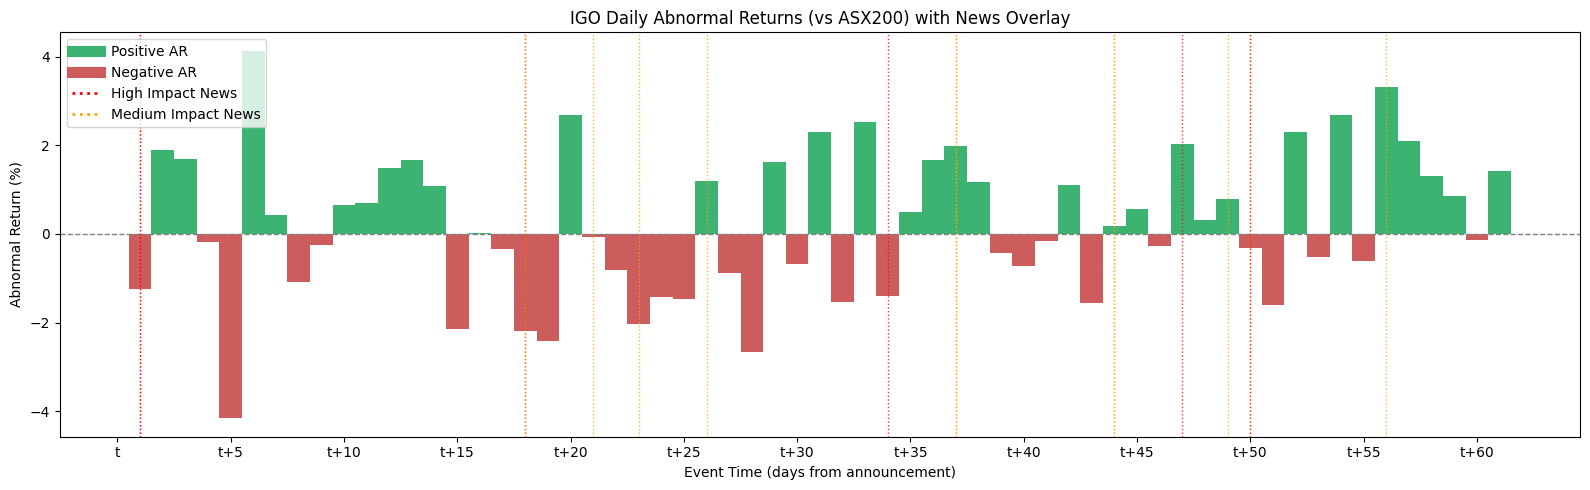

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd

# --- Prepare AR dataframe ---
df_daily = pd.DataFrame({
    "Date": igo['Date'],
    "IGO_Return": igo['IGO_Return'].values,
    "ASX200_Return": asx['ASX200_Return'].values
})
df_daily['AR'] = df_daily['IGO_Return'] - df_daily['ASX200_Return']

# --- Normalize news dates ---
igo_news['Datetime'] = pd.to_datetime(igo_news['Datetime']).dt.normalize()
df_daily['Date'] = pd.to_datetime(df_daily['Date']).dt.normalize()

# --- Create event time labels ---
labels = ['t'] + [f't+{i}' for i in range(1, len(df_daily))]

plt.figure(figsize=(16, 5))

# --- Plot daily AR bars: green for positive, red for negative ---
plt.bar(
    np.arange(len(df_daily)),
    df_daily['AR'],
    color=np.where(df_daily['AR'] >= 0, "mediumseagreen", "indianred"),
    width=1.0,
    edgecolor="none"
)
plt.axhline(0, color="grey", linestyle="--", linewidth=1)

# --- Overlay High/Medium impact news lines ---
for _, row in igo_news.iterrows():
    news_date = row['Datetime']
    impact = row['Impact']
    # Find index of the trading day on or after the news date
    trading_day_idx = df_daily.index[df_daily['Date'] >= news_date]
    if len(trading_day_idx) > 0 and impact in ['High', 'Medium']:
        x = trading_day_idx[0]
        color = 'red' if impact == 'High' else 'orange'
        plt.axvline(x, color=color, linestyle=':', alpha=0.8, linewidth=1)

# --- Custom legend entries ---
high_news_line = mlines.Line2D([], [], color='red', linestyle=':', linewidth=2, label='High Impact News')
medium_news_line = mlines.Line2D([], [], color='orange', linestyle=':', linewidth=2, label='Medium Impact News')
pos_ar_bar = mlines.Line2D([], [], color="mediumseagreen", linewidth=8, marker="_", label="Positive AR")
neg_ar_bar = mlines.Line2D([], [], color="indianred", linewidth=8, marker="_", label="Negative AR")

plt.legend(
    handles=[pos_ar_bar, neg_ar_bar, high_news_line, medium_news_line],
    loc='upper left'
)

# --- Final formatting ---
plt.title("IGO Daily Abnormal Returns (vs ASX200) with News Overlay")
plt.ylabel("Abnormal Return (%)")
plt.xlabel("Event Time (days from announcement)")
step = 5
tick_positions = np.arange(0, len(df_daily), step)
tick_labels = [labels[i] for i in tick_positions]
plt.xticks(
    ticks=tick_positions,
    labels=tick_labels,
    rotation=0
)
plt.tight_layout()
plt.show()


## **6.4 Volume and Abnormal Return (Dual Axis) Plot with News Overlay**

This dual-axis plot visualizes IGO's trading volume (bars, left axis) and abnormal returns (bars, right axis), with High/Medium impact news overlaid as vertical lines.  
Legend distinguishes between all AR/volume/news features for immediate visual clarity.


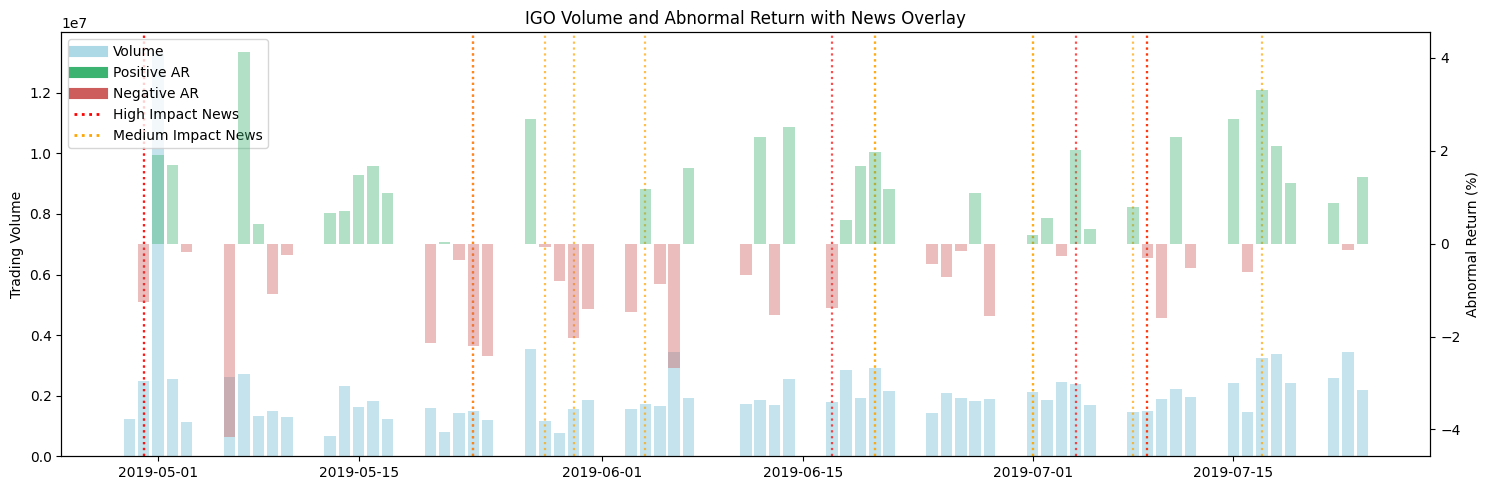

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import numpy as np

# --- Ensure all dates are normalized ---
igo['Date'] = pd.to_datetime(igo['Date']).dt.normalize()
df_daily['Date'] = pd.to_datetime(df_daily['Date']).dt.normalize()
igo_news['Datetime'] = pd.to_datetime(igo_news['Datetime']).dt.normalize()

fig, ax1 = plt.subplots(figsize=(15, 5))
ax2 = ax1.twinx()

# --- Plot trading volume on the left axis ---
ax1.bar(
    igo['Date'],
    igo['Volume'],
    color='lightblue',
    alpha=0.7,
    label='Volume'
)

# --- Prepare AR series for positive/negative coloring ---
pos_ar = df_daily['AR'].copy()
neg_ar = df_daily['AR'].copy()
pos_ar[pos_ar < 0] = 0
neg_ar[neg_ar > 0] = 0

# --- Plot abnormal returns on the right axis ---
ax2.bar(
    df_daily['Date'],
    pos_ar,
    color='mediumseagreen',
    alpha=0.4,
    label='Positive AR'
)
ax2.bar(
    df_daily['Date'],
    neg_ar,
    color='indianred',
    alpha=0.4,
    label='Negative AR'
)

# --- Overlay High/Medium impact news as vertical lines ---
for _, row in igo_news.iterrows():
    news_date = row['Datetime']
    impact = row['Impact']
    if impact in ['High', 'Medium']:
        color = 'red' if impact == 'High' else 'orange'
        ax1.axvline(
            news_date,
            color=color,
            linestyle=':',
            alpha=0.7,
            linewidth=1.6
        )

# --- Custom legend entries ---
high_news_line = mlines.Line2D([], [], color='red', linestyle=':', linewidth=2, label='High Impact News')
medium_news_line = mlines.Line2D([], [], color='orange', linestyle=':', linewidth=2, label='Medium Impact News')
vol_bar = mlines.Line2D([], [], color="lightblue", linewidth=8, marker="_", label="Volume")
pos_ar_bar = mlines.Line2D([], [], color="mediumseagreen", linewidth=8, marker="_", label="Positive AR")
neg_ar_bar = mlines.Line2D([], [], color="indianred", linewidth=8, marker="_", label="Negative AR")

ax1.legend(
    handles=[vol_bar, pos_ar_bar, neg_ar_bar, high_news_line, medium_news_line],
    loc='upper left'
)

# --- Axis labeling and title ---
ax1.set_ylabel('Trading Volume')
ax2.set_ylabel('Abnormal Return (%)')
plt.title('IGO Volume and Abnormal Return with News Overlay')
plt.tight_layout()
plt.show()



# **7. Identifying Key News Drivers Using a Composite Scoring System**

In this section, the goal is to **quantitatively identify** which specific IGO company announcements (news) were most likely responsible for significant market movements during the event window.

This is crucial because not all headlines impact price or volume in the same way — and simply knowing that “news was published” is not enough. Instead, we need a **systematic approach** that filters and ranks only the **most impactful** announcements.

---

### **Method Overview**

We apply a **composite scoring system** that combines:

1. **News Impact Classification:**
   Based on keyword analysis, each headline is classified as:

   * High → 2 points
   * Medium → 1 point
   * Low → 0 points

2. **Volume Spike:**
   If the trading volume on the news day is in the top 25% of all observed days (above the 75th percentile),
   it gets **+1 additional point**.

3. **Abnormal Return (AR) Spike:**
   If the absolute abnormal return (difference between IGO’s daily return and ASX200’s daily return) on the news day is in the top 25%,
   it gets **+1 additional point**.

---

### **Composite Score Formula**

For each news item, the final score is calculated as:

> **Composite Score = Impact Score + Volume Spike + AR Spike**

This means that to be considered a **key driver**, a headline must:

* Not only be classified as impactful (High or Medium),
* But also align with an **observable market reaction** (spike in volume or abnormal return).

---

### **Why This Matters**

This approach helps:
**Prioritize** the most important announcements for deeper qualitative analysis.
**Reduce noise** by ignoring routine or low-impact updates.
**Ensure rigor** by connecting news events to measurable price or volume responses,
rather than relying on subjective interpretation.

---

### **What Happens in Practice**

* The system scans all IGO announcements within the event window.
* It merges each headline with the matching day’s trading volume and abnormal return.
* It flags and extracts only those headlines that score **3 or more points** —
  meaning they show both high news relevance **and** strong market signals.

The final output is a **ranked list of key news drivers**, ready for further qualitative review, inclusion in reports, or detailed event study follow-up.

If needed, this framework can also be **reapplied to other companies, sectors, or time windows** by adjusting the underlying datasets.


In [ ]:
import pandas as pd
import numpy as np

def compute_key_news_igo(
    igo_news, igo, df_daily,
    source_label="IGO MarketIndex",
    start_date="2019-04-01",
    save_excel=True,
    verbose=True
):
    """
    Scores IGO news items by impact, volume spikes, and AR spikes.
    Extracts key drivers most likely associated with market reactions.

    Parameters:
        igo_news (pd.DataFrame): ['Datetime', 'Impact', 'Headline']
        igo (pd.DataFrame): ['Date', 'Volume']
        df_daily (pd.DataFrame): ['Date', 'AR']
        source_label (str): Source label for report naming
        start_date (str): Earliest date to include (YYYY-MM-DD)
        save_excel (bool): Save filtered news to Excel
        verbose (bool): Print output to screen

    Returns:
        pd.DataFrame: Filtered DataFrame of key news with composite scores.
    """
    # Normalize dates and filter to start_date
    igo_news = igo_news.copy()
    igo = igo.copy()
    igo['Date'] = pd.to_datetime(igo['Date']).dt.normalize()
    df_daily = df_daily.copy()
    df_daily['Date'] = pd.to_datetime(df_daily['Date']).dt.normalize()

    # Cast Volume and AR to numeric
    igo['Volume'] = pd.to_numeric(igo['Volume'], errors='coerce')
    df_daily['AR'] = pd.to_numeric(df_daily['AR'], errors='coerce')

    # Filter to start_date (inclusive)
    start_date = pd.to_datetime(start_date)
    igo_news = igo_news[igo_news['Date'] >= start_date]
    igo = igo[igo['Date'] >= start_date]
    df_daily = df_daily[df_daily['Date'] >= start_date]

    # Merge with volume and AR
    merged = (
        igo_news.merge(igo[['Date', 'Volume']], on='Date', how='left')
                .merge(df_daily[['Date', 'AR']], on='Date', how='left')
    )

    # Assign impact scores
    impact_dict = {"High": 2, "Medium": 1}
    merged['ImpactScore'] = merged['Impact'].map(impact_dict).fillna(0).astype(int)

    # Calculate Q3 thresholds (ignoring NaN)
    volume_q3 = merged['Volume'].dropna().quantile(0.70)
    ar_q3 = merged['AR'].abs().dropna().quantile(0.70)

    # Identify spikes
    merged['VolumeSpike'] = (merged['Volume'] >= volume_q3)
    merged['ARSpike'] = (merged['AR'].abs() >= ar_q3)

    # Compute composite score
    merged['CompositeScore'] = (
        merged['ImpactScore']
        + merged['VolumeSpike'].astype(int)
        + merged['ARSpike'].astype(int)
    )

    # Filter to key drivers (CompositeScore ≥ 3)
    key_news = merged[merged['CompositeScore'] >= 3].copy()
    cols_to_show = [
        'Date', 'Headline', 'Impact', 'ImpactScore',
        'Volume', 'VolumeSpike', 'AR', 'ARSpike', 'CompositeScore'
    ]
    key_news = key_news[cols_to_show].sort_values('Date').reset_index(drop=True)

    # Optional: Add summary statistics
    if verbose:
        print(f"\n=== Key News Drivers from {source_label} ===")
        if key_news.shape[0] == 0:
            print("No key news drivers found in selected period.")
        else:
            print(key_news.to_string(index=False))
            print(f"\n[INFO] Found {key_news.shape[0]} high-impact news days between {start_date.date()} and {merged['Date'].max().date()}.")
        print(f"[INFO] Volume spike threshold (top 30%): {volume_q3:,.0f}")
        print(f"[INFO] AR spike threshold (top 30%, absolute): {ar_q3:.2f}")

        # Optionally: Count by month
        if key_news.shape[0] > 0:
            counts_by_month = key_news.groupby(key_news['Date'].dt.to_period("M")).size()
            print(f"\n[INFO] Distribution by month:\n{counts_by_month}")

    # Optionally save to Excel
    if save_excel and key_news.shape[0] > 0:
        fname = f"Key_News_with_Score_{source_label.replace(' ', '_')}.xlsx"
        key_news.to_excel(fname, index=False)
        if verbose:
            print(f"[INFO] Results saved to: {fname}")

    return key_news

# --- Esempio di uso ---
key_news_igo = compute_key_news_igo(igo_news, igo, df_daily, source_label="IGO MarketIndex")

key_news_igo



=== Key News Drivers from IGO MarketIndex ===
      Date                                                      Headline Impact  ImpactScore    Volume  VolumeSpike        AR  ARSpike  CompositeScore
2019-04-30                       March 2019 Quarterly Activities Report$   High            2 2469731.0         True -1.245518    False               3
2019-04-30                              March 2019 Quarter Presentation$   High            2 2469731.0         True -1.245518    False               3
2019-05-23        MCR: Mincor to acquire Long Nickel Operation from IGO$   High            2 1481102.0        False -2.193532     True               3
2019-06-20 AMD:Independence Group Completes Farm-in at Plumridge Nickel$ Medium            1 2919291.0         True  1.977938     True               3
2019-06-20        MOH: GOLD EXPLORATION DRILLING UPDATE EMPRESS SPRINGS$ Medium            1 2919291.0         True  1.977938     True               3
2019-07-04        Nova Operation Exceeds FY19 M

,Date,Headline,Impact,ImpactScore,Volume,VolumeSpike,AR,ARSpike,CompositeScore
0,2019-04-30,March 2019 Quarterly Activities Report$,High,2,2469731.0,True,-1.245518,False,3
1,2019-04-30,March 2019 Quarter Presentation$,High,2,2469731.0,True,-1.245518,False,3
2,2019-05-23,MCR: Mincor to acquire Long Nickel Operation f...,High,2,1481102.0,False,-2.193532,True,3
3,2019-06-20,AMD:Independence Group Completes Farm-in at Pl...,Medium,1,2919291.0,True,1.977938,True,3
4,2019-06-20,MOH: GOLD EXPLORATION DRILLING UPDATE EMPRESS ...,Medium,1,2919291.0,True,1.977938,True,3
5,2019-07-04,Nova Operation Exceeds FY19 Metal Production G...,High,2,2382707.0,True,2.023892,True,4
6,2019-07-17,PRX: More Copper and Cobalt intersected at Lak...,Medium,1,3237536.0,True,3.312375,True,3


# **8. Beta Analysis – IGO vs ASX200**

This section estimates IGO’s beta relative to the ASX200 to assess market risk exposure and benchmark suitability.

**Objectives:**
- Download daily price data for IGO and ASX200 (Yahoo Finance).
- Compute daily log returns for both series.
- Estimate static (full-period) beta using OLS regression.
- Calculate rolling (windowed) beta to detect time-variation.
- Test for changes in beta before/after the March 2019 earnings event.

**Key outcomes:**
- Validate if ASX200 is an appropriate benchmark for IGO.
- Detect any event-driven shifts in IGO’s systematic risk.

All code and plots are reproducible below.


## **8.1 Data Download and Preparation**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download daily close prices for IGO.AX and ASX200 (^AXJO)
tickers = ['IGO.AX', '^AXJO']
data = yf.download(tickers, start='2017-01-01', end='2020-01-01')['Close']

# Drop missing values for robust analysis
data = data.dropna()

# Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()
returns.columns = ['IGO', 'ASX200']

data


[*********************100%***********************]  2 of 2 completed


Ticker,IGO.AX,^AXJO
Date,,
2017-01-03,3.618161,5733.200195
2017-01-04,3.626421,5736.399902
2017-01-05,3.667725,5753.299805
2017-01-06,3.642942,5755.600098
2017-01-09,3.675985,5807.399902
...,...,...
2019-12-23,5.314979,6785.100098
2019-12-24,5.297970,6794.200195
2019-12-27,5.553089,6821.700195


## **8.2 Static Beta Estimation (Full Sample)**

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(returns['ASX200'])
y = returns['IGO']
model = sm.OLS(y, X).fit()
beta_full = model.params['ASX200']

print(f"Static beta (full sample): {beta_full:.3f}")
print(model.summary())


Static beta (full sample): 1.324
                            OLS Regression Results                            
Dep. Variable:                    IGO   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     119.3
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           6.91e-26
Time:                        04:00:23   Log-Likelihood:                 1809.7
No. Observations:                 755   AIC:                            -3615.
Df Residuals:                     753   BIC:                            -3606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.00

## **Rolling Beta Estimation and Plot (120-day window)**

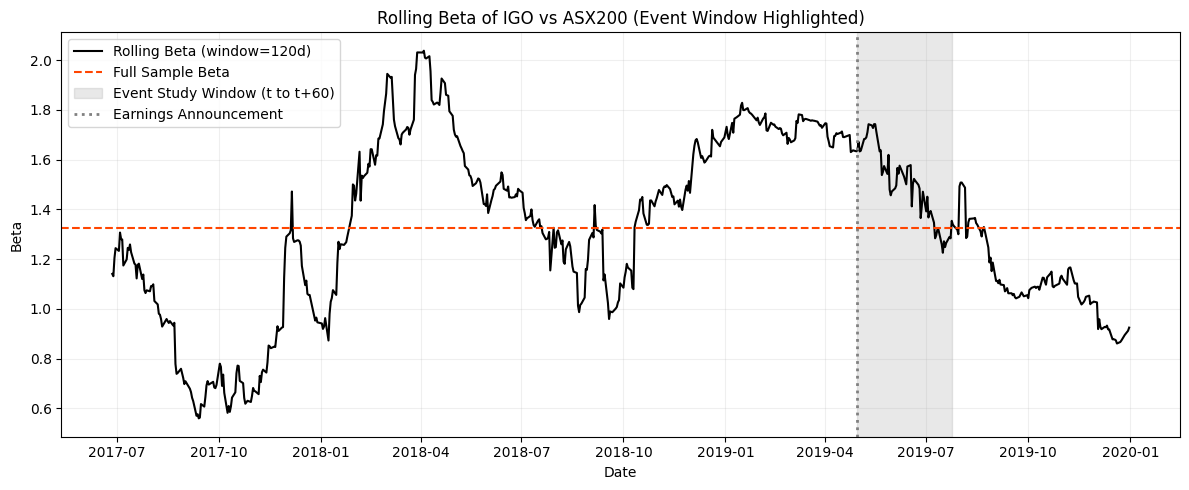

In [ ]:
import matplotlib.pyplot as plt

window = 120
rolling_betas = (
    returns['IGO']
    .rolling(window=window)
    .cov(returns['ASX200'])
    / returns['ASX200'].rolling(window=window).var()
)

event_date = pd.to_datetime('2019-04-30')
event_pos = returns.index.get_loc(event_date)
t_plus_60 = returns.index[min(event_pos + 60, len(returns) - 1)]

plt.figure(figsize=(12, 5))
plt.plot(rolling_betas, label=f'Rolling Beta (window={window}d)', color='black')
plt.axhline(beta_full, color='orangered', linestyle='--', label='Full Sample Beta')
plt.axvspan(event_date, t_plus_60, color='grey', alpha=0.18, label='Event Study Window (t to t+60)')
plt.axvline(event_date, color='grey', linestyle=':', linewidth=2, label='Earnings Announcement')
plt.title('Rolling Beta of IGO vs ASX200 (Event Window Highlighted)')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


## **8.4 Regime Beta Estimation: Pre/Post Matched Windows + Full Sample Overlay**

Pre-event Beta  (last 120 days before 2019-04-30): 1.633
Post-event Beta (first 120 days from   2019-04-30): 1.109
Full sample Beta: 1.324
N pre: 120, N post: 120


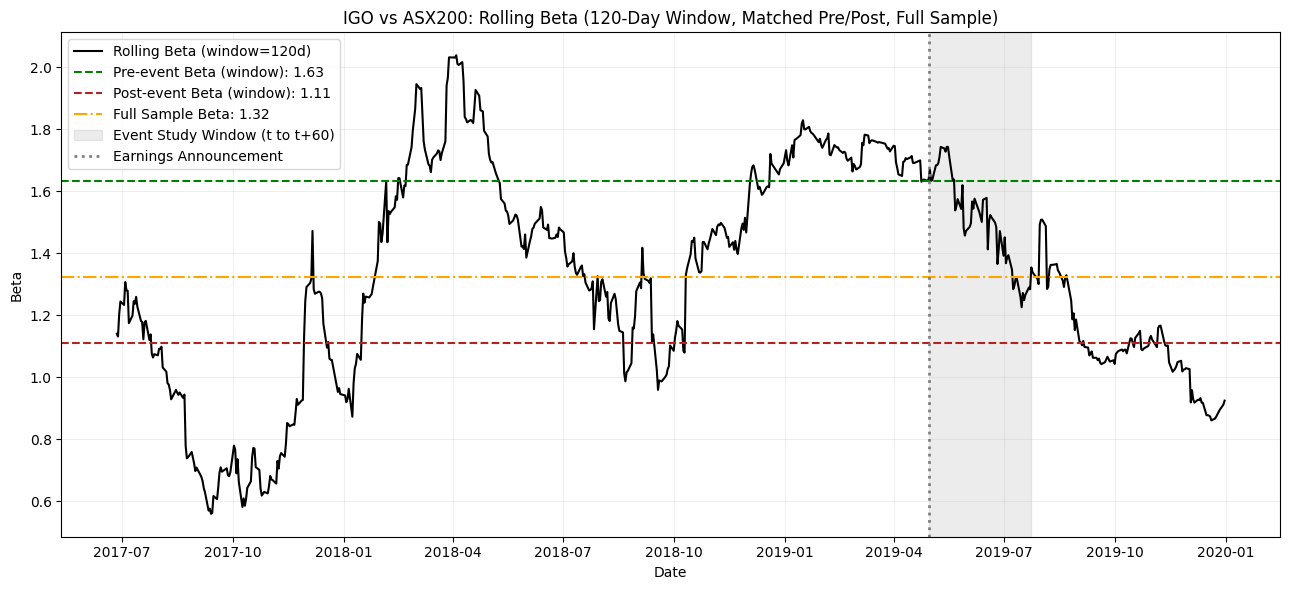

In [ ]:
# Define matched window (e.g., 120 days before and after event)
regime_window = 120
event_pos = returns.index.get_loc(event_date)
pre_event = returns.iloc[event_pos - regime_window:event_pos]
post_event = returns.iloc[event_pos:event_pos + regime_window]

def compute_beta(X, y):
    Xc = sm.add_constant(X)
    results = sm.OLS(y, Xc).fit()
    return results.params['ASX200']

beta_pre = compute_beta(pre_event['ASX200'], pre_event['IGO'])
beta_post = compute_beta(post_event['ASX200'], post_event['IGO'])
full_beta = compute_beta(returns['ASX200'], returns['IGO'])

print(f"Pre-event Beta  (last {regime_window} days before {event_date.date()}): {beta_pre:.3f}")
print(f"Post-event Beta (first {regime_window} days from   {event_date.date()}): {beta_post:.3f}")
print(f"Full sample Beta: {full_beta:.3f}")
print(f"N pre: {len(pre_event)}, N post: {len(post_event)}")

# Rolling beta + overlay all regime betas and event window
plt.figure(figsize=(13, 6))
plt.plot(rolling_betas, label=f'Rolling Beta (window={window}d)', color='black')
plt.axhline(beta_pre, color='green', linestyle='--', label=f'Pre-event Beta (window): {beta_pre:.2f}')
plt.axhline(beta_post, color='firebrick', linestyle='--', label=f'Post-event Beta (window): {beta_post:.2f}')
plt.axhline(full_beta, color='orange', linestyle='-.', label=f'Full Sample Beta: {full_beta:.2f}')
plt.axvspan(event_date, t_plus_60, color='grey', alpha=0.15, label='Event Study Window (t to t+60)')
plt.axvline(event_date, color='grey', linestyle=':', linewidth=2, label='Earnings Announcement')

plt.title('IGO vs ASX200: Rolling Beta (120-Day Window, Matched Pre/Post, Full Sample)')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



## **8.5 Summary Table**

In [ ]:
print(f"{'Window':<30}{'Beta':>9}")
print("-"*40)
print(f"Pre-event (last {window} days)    {beta_pre:>10.3f}")
print(f"Post-event (first {window} days)  {beta_post:>10.3f}")
print(f"Full Sample (all data)            {full_beta:>4.3f}")


Window                             Beta
----------------------------------------
Pre-event (last 120 days)         1.633
Post-event (first 120 days)       1.109
Full Sample (all data)            1.324
